In [1]:
import os
import glob
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
import copy


%matplotlib notebook

In [2]:
working_directory = r"D:\Files_Reutlingen_Jenny\main_191023\191023_paper"

output_directory = r"D:\Files_Reutlingen_Jenny\main_191023\191023_paper\analysis_spontaneous"

In [3]:
os.chdir(working_directory)

In [4]:
filename= 'spontaneous'

In [5]:
folderlist = glob.glob('*from*')

In [6]:
folderlist

['spontaneous_DNQX_AP5_washin0001_from_0_to_120_analyzed_on_19082021',
 'spontaneous_DNQX_AP5_washin_from_0_to_120_analyzed_on_19082021',
 'spontaneous_from_0_to_120_analyzed_on_19082021',
 'spontaneous_from_1080_to_1200_analyzed_on_19082021',
 'spontaneous_from_120_to_240_analyzed_on_19082021',
 'spontaneous_from_240_to_360_analyzed_on_19082021',
 'spontaneous_from_360_to_480_analyzed_on_19082021',
 'spontaneous_from_480_to_600_analyzed_on_19082021',
 'spontaneous_from_600_to_720_analyzed_on_19082021',
 'spontaneous_from_720_to_840_analyzed_on_19082021',
 'spontaneous_from_840_to_960_analyzed_on_19082021',
 'spontaneous_from_960_to_1080_analyzed_on_19082021',
 'spontaneous_hCSF_afterDNQX_AP5_washin_from_0_to_120_analyzed_on_19082021']

In [7]:
# for now just the first 3 to make the manuscript
folderlist = folderlist[2:-1]

In [8]:
folderlist

['spontaneous_from_0_to_120_analyzed_on_19082021',
 'spontaneous_from_1080_to_1200_analyzed_on_19082021',
 'spontaneous_from_120_to_240_analyzed_on_19082021',
 'spontaneous_from_240_to_360_analyzed_on_19082021',
 'spontaneous_from_360_to_480_analyzed_on_19082021',
 'spontaneous_from_480_to_600_analyzed_on_19082021',
 'spontaneous_from_600_to_720_analyzed_on_19082021',
 'spontaneous_from_720_to_840_analyzed_on_19082021',
 'spontaneous_from_840_to_960_analyzed_on_19082021',
 'spontaneous_from_960_to_1080_analyzed_on_19082021']

In [9]:
# get into every folder and find the dictionaries
# replace them in a two meta-dictionaries (infodics and spikedics)
infodics = {}
spikedics = {}

for folder in folderlist:
    os.chdir(os.path.join(working_directory, folder))
    timekey = folder.split('_')[2:5]
    timekey = '_'.join(timekey)
    
    # load the info_dic_file
    info_dic_filename = glob.glob('*info*')[0]
    info_dic = np.load(info_dic_filename, allow_pickle=True).item()
    infodics[timekey] = info_dic
    
    # load the spikedic_file
    spike_dic_filename = glob.glob('*spikes_MAD*')[0]
    spikedic_MAD = np.load(spike_dic_filename, allow_pickle=True).item()
    spikedics[timekey] = spikedic_MAD
    


In [10]:
info_dic

{'tick': 40,
 'timelengthrecording_s': 1200.0,
 'first_recording_timepoint': 0,
 'scale_factor_for_second': 1e-06,
 'network_burst_threshold_basline': 45.15558946967146}

We now have the a dictionary of dictionaries for the info-dic and a dictionary of dictionaries for the spikedics.

Next, we want to rejoin the subdictionaries again.
    

In [11]:
# we gather the general information
infodic = infodics['0_to_120']

tick = infodic['tick']
# the timelength recording must be set to 120 seconds if we observe
timelengthrecording_s = 120
first_recording_timepoint = infodic['first_recording_timepoint']
scale_factor_for_second = infodic['scale_factor_for_second']




In [12]:
info_dic_filename

'spontaneous.h5_960_1080_info_dict.npy'

In [13]:
# cross this out if you want them in the original directory
os.chdir(output_directory)

### subrecordings analysis

Here we define one of the subrecording and will procede with the analysis for that subpart

if we want to proceed with only a subrecording, we rename the filename to the key

In [14]:
# first we define the subpart we want to observe and load the spikedic MAD accordingly
timekey = '0_to_120'

spikedic_MAD = spikedics[timekey]


In [15]:
filename = filename + '_' + timekey

In [16]:
 # create an array of the spikes in scale of seconds
active_channels = 0
spikedic_seconds = {}
for key in spikedic_MAD:
    relevant_factor = timelengthrecording_s*0.05
    if len(spikedic_MAD[key])>relevant_factor:
        sec_array = np.asarray(spikedic_MAD[key])*tick*scale_factor_for_second
        spikedic_seconds[key]=sec_array
        active_channels += 1
spikearray_seconds = np.asarray(list(spikedic_seconds.values()))  

In [17]:
# see the relevant factor, i.e. how many spikes a need to be detected in a channel to consider it for further analysis
timelengthrecording_s*0.05



6.0

In [18]:
active_channels

70

In [19]:
# get a 1-D array with every detected spike
scale_factor_for_milisecond = 1e-03
full_spike_list = []
full_spike_list_seconds = []
for key in spikedic_MAD:
    if len(spikedic_MAD[key])>relevant_factor:
        x = list(np.asarray(spikedic_MAD[key])*scale_factor_for_milisecond*tick)
        full_spike_list = full_spike_list + x

        xs = list(np.asarray(spikedic_MAD[key])*scale_factor_for_second*tick)
        full_spike_list_seconds = full_spike_list_seconds + xs
full_spikes = sorted(full_spike_list)
full_spikes_seconds = sorted(full_spike_list_seconds)

In [20]:
mean_fr_whole_recording = np.around((len(full_spikes_seconds) / timelengthrecording_s), 3)

In [21]:
mean_fr_whole_recording

76.175

In [22]:
 #define bins 
binsize = 0.005 #seconds
bins= np.arange(0, timelengthrecording_s+binsize, binsize)

# make a histogram 
full_spikes_binned = np.histogram(full_spikes_seconds, bins)[0]


#trial of population burst plot as inspired by Andrea Corna
bins = int(timelengthrecording_s / binsize)+1

firing_rate_histogram = np.histogram(full_spikes_seconds, bins=bins)
firing_rate = firing_rate_histogram[0]*200 #conversion to hertz

In [23]:
def gaussian_smoothing(y, window_size=10, sigma=2):

    filt = signal.gaussian(window_size, sigma)

    return signal.convolve(y, filt, mode='full')


<IPython.core.display.Javascript object>


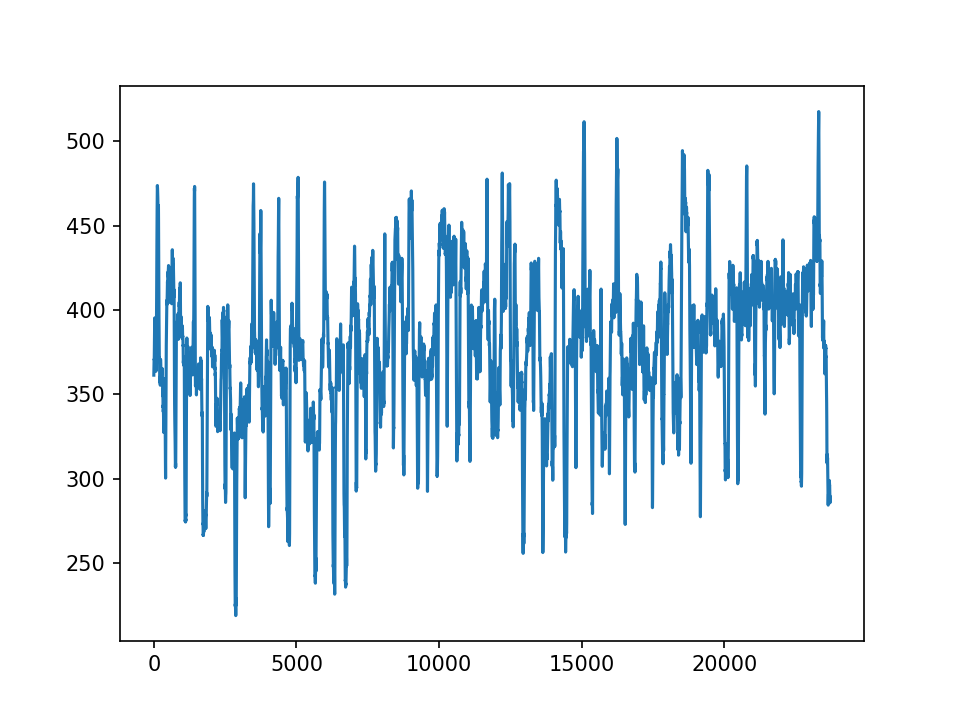

In [24]:
N = int(1.5/binsize) # für eine Secunde, das Sliding window, also letztlich number of bins

# gaussian smmothing fo the firing rate and moving average
fr_gau = gaussian_smoothing(firing_rate)
ma_fr_gau = np.convolve(fr_gau, np.ones(N)/N, mode='valid')
plt.plot(ma_fr_gau)

In [25]:
# we look for the mean of the MA as threshold
# we arrange this mean in an array for plotting
mean_ma_fr_gau = np.mean(ma_fr_gau)
std_ma_fr_gau = np.std(ma_fr_gau)
network_burst_threshold = mean_ma_fr_gau
shape_for_threshold = np.shape(ma_fr_gau)
network_burst_threshold_array = np.full(shape_for_threshold, network_burst_threshold)
    

In [26]:
#network_burst_threshold = 1*std_ma_fr_gau

In [27]:
# now we identify the burts from the network and will extract an array with 
# tuples containing the burst start and end times
bursts= []
burst_start = []
burst_seconds_start = []
burst_end = []
burst_seconds_end = []
for index in range(0, len(ma_fr_gau[:-N])):
    if ma_fr_gau[index+N] > network_burst_threshold:
        if ma_fr_gau[index+N-1] <= network_burst_threshold:
            burst_start.append(index+N)
        if index == 0:
            burst_start.append(0)
            #burst_seconds_start.append((index+N)*0.005)
    else:
        if (ma_fr_gau[index+N-1] > network_burst_threshold) and (len(burst_start)>0):
            if index+N > len(ma_fr_gau):
                ending = len(ma_fr_gau)
            else: 
                ending = index + N

            burst_end.append(ending)
            #burst_seconds_end.append((ending)*0.005)
bursts = list(zip(burst_start, burst_end))
    

In [28]:
# get the bursts into seconds
for i in burst_start:
    burst_seconds_start.append(firing_rate_histogram[1][i])
for i in burst_end:
    burst_seconds_end.append(firing_rate_histogram[1][i])

bursts_seconds = list(zip(burst_seconds_start, burst_seconds_end))
# bursts sind jetzt im 5ms bin 
    

<IPython.core.display.Javascript object>


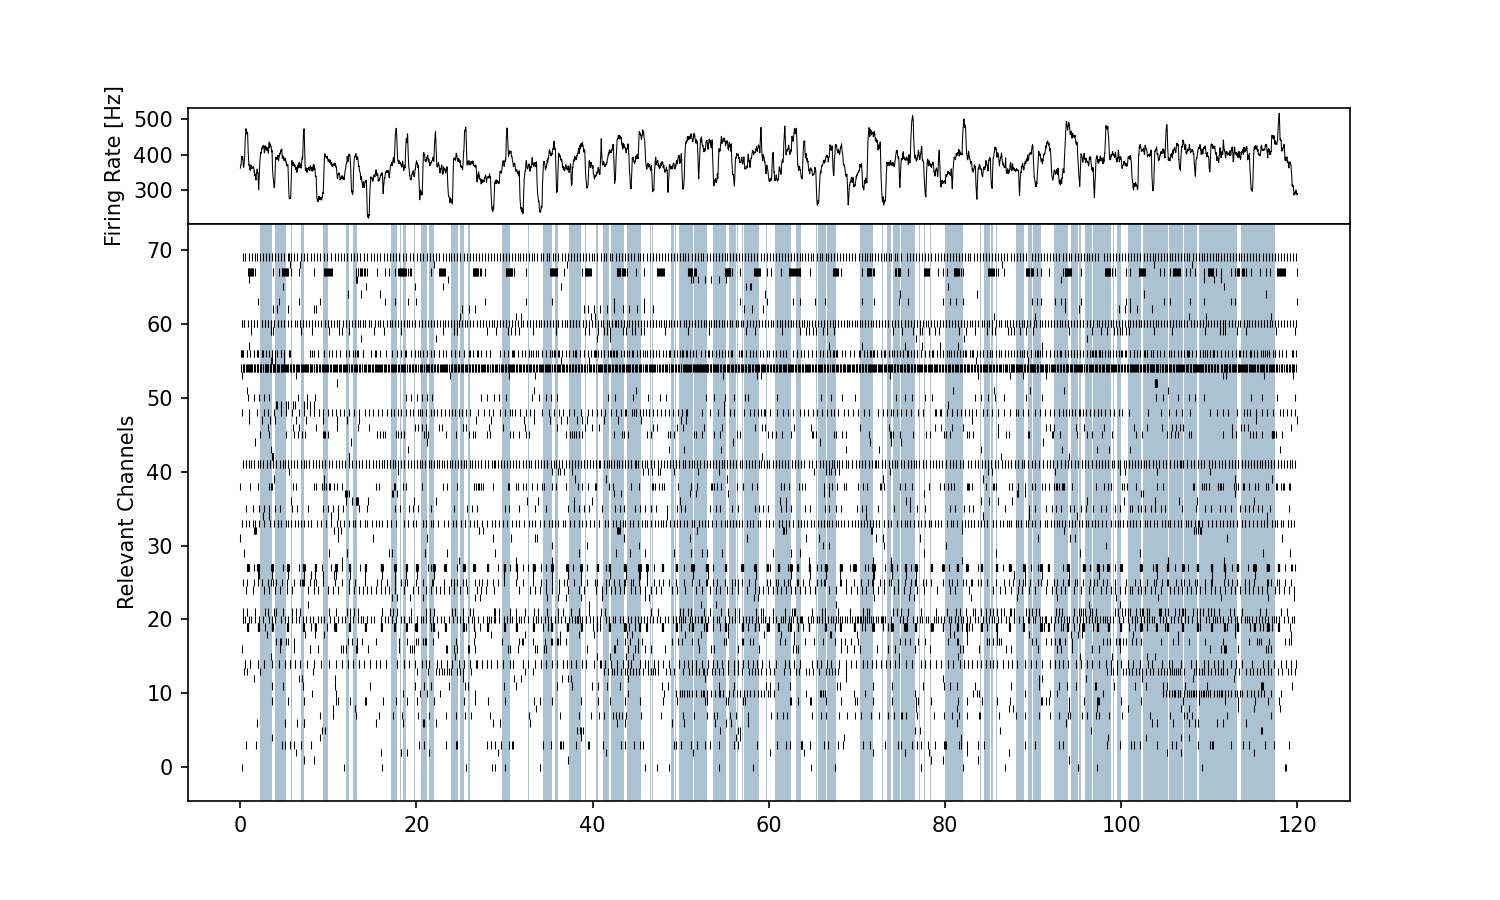

<ipython-input-29-4f779ef7dca5>:6: MatplotlibDeprecationWarning: "color" keyword argument will be ignored
  axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.5,


In [29]:
fig = plt.figure(figsize = (10,6))
gs = fig.add_gridspec(2, hspace = 0, height_ratios=[1,5])
axs = gs.subplots(sharex=False, sharey=False)
axs[0].plot(ma_fr_gau, color= 'black', linewidth = 0.5)
axs[0].set_ylabel('Firing Rate [Hz]')
axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.5,
                 linelengths = 1, colors = 'black')
axs[1].set_ylabel('Relevant Channels')

for ax in axs:
    for i in bursts_seconds:
        axs[1].axvspan(i[0], i[1], facecolor = '#5B89A6', alpha = 0.3)
#fig.savefig(filename+ '__raster_firingrate_plot.png', dpi=300)



<IPython.core.display.Javascript object>


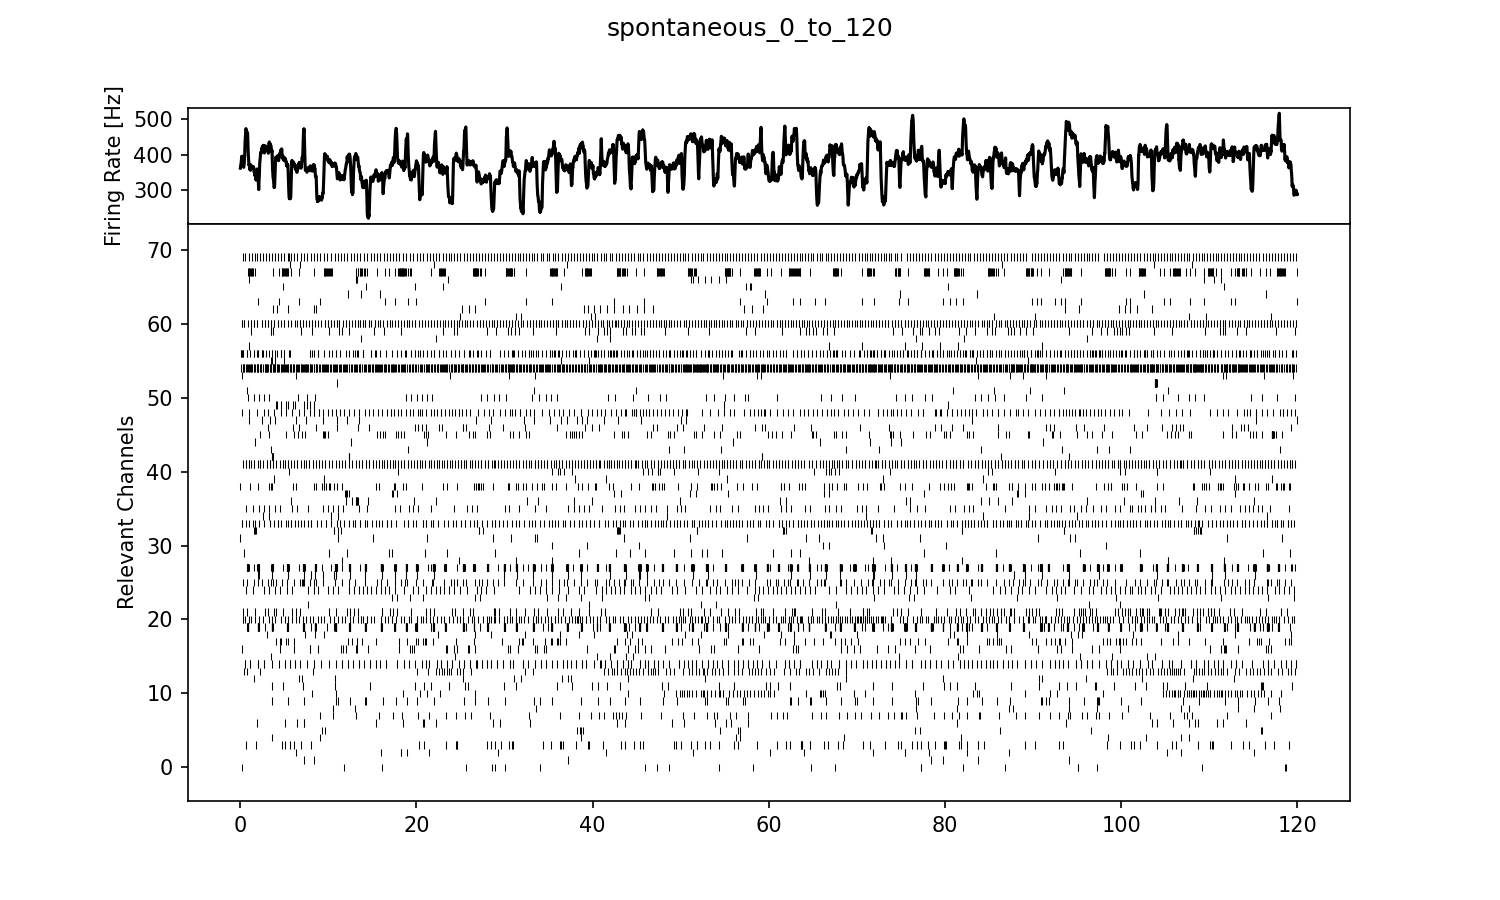

<ipython-input-30-c4b666c2c0f1>:6: MatplotlibDeprecationWarning: "color" keyword argument will be ignored
  axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.5,


Text(0.5, 0.98, 'spontaneous_0_to_120')

In [30]:
fig = plt.figure(figsize = (10,6))
gs = fig.add_gridspec(2, hspace = 0, height_ratios=[1,5])
axs = gs.subplots(sharex=False, sharey=False)
axs[0].plot(ma_fr_gau, color= 'black')
axs[0].set_ylabel('Firing Rate [Hz]')
axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.5,
                 linelengths = 1, colors = 'black')
axs[1].set_ylabel('Relevant Channels')
fig.suptitle(filename)

#for ax in axs:
#    for i in bursts_seconds:
#        axs[1].axvspan(i[0], i[1], facecolor = '#5B89A6', alpha = 0.3)
#fig.savefig(filename+ '__raster_firingrate_plot_solo.png', dpi=300)

In [31]:
# identify the longest burst and longest interburst-interval


In [32]:
#longest bursts:

longest_burst = 0
longest_burst_i = 0
for i in bursts_seconds:
    burstinterval = i[1]-i[0]
    if burstinterval > longest_burst:
        longest_burst = burstinterval
        longest_burst_i = i

In [33]:
# longest_interburst interval:

longest_ibi = 0
longest_ibi_times = (0, 0)

for i in range(1, len(bursts_seconds)-1):
    ibi = bursts_seconds[i+1][0] - bursts_seconds[i][1]
    if ibi > longest_ibi:
        longest_ibi = ibi
        longest_ibi_times = ((bursts_seconds[i][1]), (bursts_seconds[i+1][0])) 

In [34]:
longest_ibi_times

(13.252561454939377, 16.996328152993627)

<IPython.core.display.Javascript object>


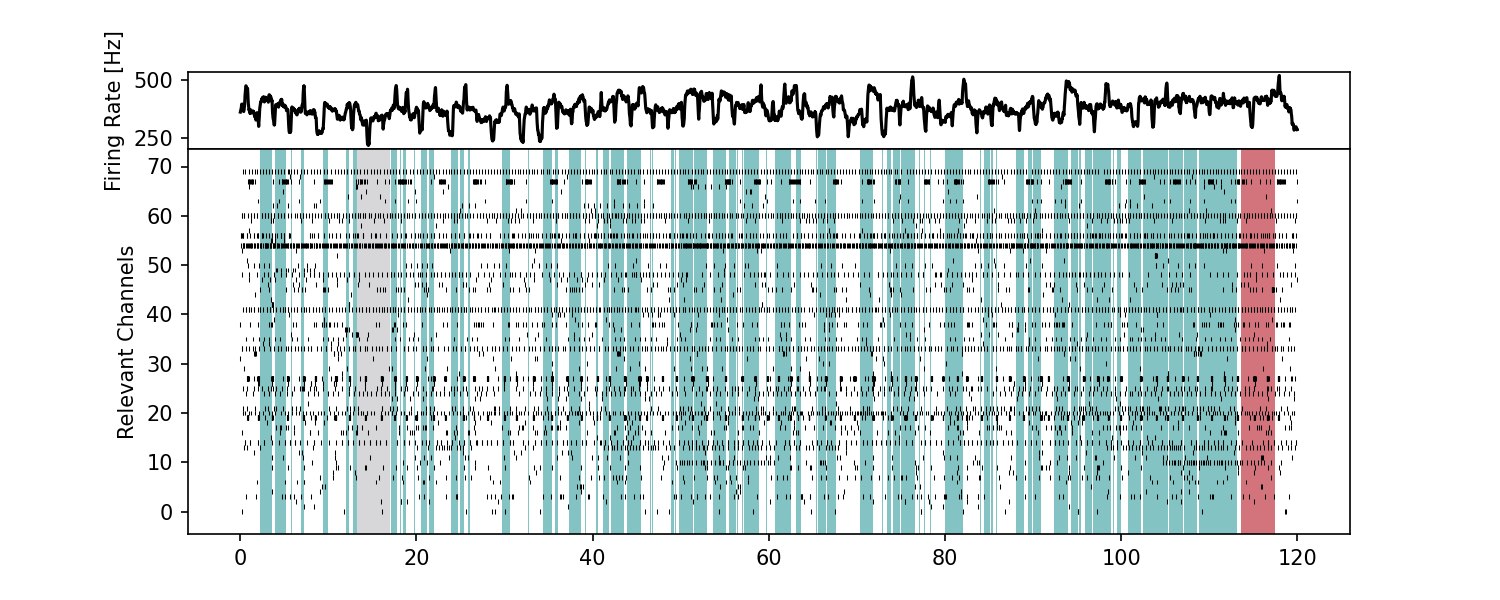

In [35]:
fig = plt.figure(figsize = (10,4))
gs = fig.add_gridspec(2, hspace = 0, height_ratios=[1,5])
axs = gs.subplots(sharex=False, sharey=False)
axs[0].plot(ma_fr_gau, color= 'black')
axs[0].set_ylabel('Firing Rate [Hz]')
axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.5, linelengths = 1)
axs[1].set_ylabel('Relevant Channels')

for ax in axs:
    for i in bursts_seconds:
        axs[1].axvspan(i[0], i[1], facecolor = '#118C8C', alpha = 0.3)
        axs[1].axvspan(longest_burst_i[0], longest_burst_i[1], facecolor = '#F2727D', alpha = 0.2, label = 'longest network burst')
        axs[1].axvspan(longest_ibi_times[0], longest_ibi_times[1], facecolor = '#D7D7D9', alpha = 0.1, ls =':')
        
#fig.savefig(filename+'raster_and_FR_plot.png', dpi=300)
        


In [36]:
# next, we want to isolate these two areas for a spade analysis

In [37]:
def subdivide_spiketrain(spiketrain, sub_start = 0, sub_stop = 10, tick=40, scale_factor_for_second=1e-06):
    '''
    Excpects: 
        a spiketrain with tick datapoints
        default ticks are 40
        default scale_factor_for_seconds = 1e-06
        provide the start and stop of the desired sub in seconds
    
    Does:
        converts the desired seconds into data ticks
        checks if the spikes of the given spiketrain is in the desired subs
        substracts the starting time -->
        
    Returns:
        a spiketrain dictionary that again starts from zero
    
    '''
    sub_start_tick = sub_start / (tick*scale_factor_for_second)
    sub_stop_tick = sub_stop / (tick*scale_factor_for_second)
    sub_spiketrain = {}
  
    for key in spiketrain: 
        list_per_key = []
        for i in spiketrain[key]:
            if (i>=sub_start_tick ) & (i<sub_stop_tick):
                list_per_key.append(int(i-sub_start_tick))
        sub_spiketrain[key]=list_per_key

    return sub_spiketrain

In [38]:
burst_seconds_start

[2.206200436648473,
 3.965620834131911,
 5.795018179242531,
 5.9949523153201945,
 6.904652634473563,
 9.433819455856005,
 10.038620217490937,
 11.977981337444273,
 12.7627228215491,
 16.996328152993627,
 17.126285341444106,
 17.281234296904298,
 17.821056464313987,
 17.876038351735346,
 18.190934616057664,
 18.52082594058581,
 19.7454225240615,
 20.520167301362445,
 21.42986762051581,
 21.474852801133288,
 23.924045968084663,
 24.63881050456231,
 25.003690302904047,
 25.48853058289238,
 25.608491064538978,
 25.863407088038,
 26.033351103704014,
 29.45222483063206,
 29.67715073371943,
 32.05636695304362,
 32.70115454189409,
 33.21598494229407,
 34.040713253614435,
 34.100693494437735,
 34.41558975876005,
 34.490565059789176,
 35.68517152285322,
 37.349623205699764,
 39.119040309987085,
 40.39362042748219,
 40.753501872421985,
 41.13837508437148,
 42.14304411816174,
 43.96244475646848,
 44.272342667388855,
 46.541595111870336,
 46.75652430815383,
 47.29134812216158,
 47.38131848339653,
 

In [39]:
burst_seconds_end

[3.6107377425940586,
 5.170224003999833,
 5.830006653056122,
 5.9999506687221364,
 7.27453078621724,
 10.018626803883171,
 10.138587285529768,
 12.372851256197658,
 13.252561454939377,
 17.001326506395568,
 17.26623923669847,
 17.786067990500396,
 17.86104329152952,
 17.911026825548937,
 18.23591979667514,
 18.880707385525604,
 19.805402764884796,
 21.194945010624558,
 21.44986103412358,
 22.039666735552686,
 24.623815444356485,
 24.678797331777844,
 25.443545402274907,
 25.51852070330403,
 25.67846801216616,
 25.953377449272946,
 26.14331487854673,
 29.52220177825924,
 30.581852699470854,
 32.12134554726887,
 32.78612654972709,
 33.2309800024999,
 34.08070008082996,
 34.135681968251326,
 34.480568352985294,
 35.38527031873672,
 36.11502991542019,
 38.69418027082205,
 39.219007378025914,
 40.60355127036374,
 40.78849034623558,
 41.91311986167243,
 43.622556725136455,
 44.20736407316362,
 45.48194419065872,
 46.63656382650723,
 46.85149302279072,
 47.326336595975164,
 47.396313543602346

In [40]:
st_longest_burst = subdivide_spiketrain(spikedic_MAD, longest_burst_i[0], longest_burst_i[1])

In [41]:
st_longest_ibi = subdivide_spiketrain(spikedic_MAD, longest_ibi_times[0], longest_ibi_times[1])

In [42]:
# in the next step, we want to find the firing rates for every channel in hertz for these subdivisions

longest_burst_firingrate_dic = {}

for key in st_longest_burst:
    fr_channel = len(st_longest_burst[key])/longest_burst # i.e, number of spikes divided by duration -> results in number per second
    longest_burst_firingrate_dic[key] = fr_channel

In [43]:
# same is done for the longest interburst interval

longest_ibi_firingrate_dic = {}

for key in st_longest_ibi:
    fr_channel = len(st_longest_ibi[key])/longest_ibi # i.e, number of spikes divided by duration -> results in number per second
    longest_ibi_firingrate_dic[key] = fr_channel

In [44]:
# and lastly for the whole recording

whole_recording_firingrate_dic = {}

for key in spikedic_MAD:
    fr_channel = len(spikedic_MAD[key])/timelengthrecording_s # i.e, number of spikes divided by duration -> results in number per second
    whole_recording_firingrate_dic[key] = fr_channel

In [45]:
# next we plot this on a mea array:

mea_array=np.empty((16,16,))
mea_array[:]=np.nan
columnlist =['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','R']
df = pd.DataFrame(data=mea_array,columns=columnlist)
df.index+=1

df1 = pd.DataFrame(data=mea_array,columns=columnlist)
df1.index+=1

df2 = pd.DataFrame(data=mea_array,columns=columnlist)
df2.index+=1


In [46]:
# function to fill the dataframe with the 

def get_dict_values(df, dic):
    
    for i in df.columns:
        for j in range(0, 16):
            keystring = i+str(df.index[j])
            #print(keystring)
            if keystring in dic.keys():
                df.loc[df.index[j],i]=dic[keystring]
            
                
    
    return df

In [47]:
use_df_copy = df.copy()
use_df_copy1 = df1.copy()
use_df_copy2 = df2.copy()

In [48]:
#the dataframe for burst


df_fr_burst = get_dict_values(use_df_copy, longest_burst_firingrate_dic)

In [49]:
df_fr_burst

A         B         C         D         E         F         G  \
1        NaN  0.000000  0.000000  0.000000  1.316223  0.000000  1.579468   
2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  1.842712   
3   0.000000  0.000000  0.526489  0.000000  0.000000  0.000000  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.000000  0.000000  0.263245  0.263245  0.000000  0.000000  0.000000   
6   0.000000  2.105957  0.000000  0.000000  0.000000  0.000000  0.000000   
7   5.001647  0.000000  0.000000  0.000000  0.000000  0.000000  4.211913   
8   2.105957  0.000000  0.526489  0.000000  0.263245  0.263245  0.000000   
9   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.263245   
10  0.000000  0.000000  0.000000  0.000000  2.369201  0.526489  0.000000   
11  0.263245  0.263245  0.000000  0.000000  0.000000  3.948669  2.895690   
12  0.000000  0.263245  0.000000  0.000000  0.000000  7.634093  0.000000   
13  5.791381  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
14  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.263245   
15  0.000000  0.000000  0.000000  0.000000  0.263245  0.000000  0.000000   
16       NaN  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           H    I         K         L         M         N         O         P  \
1   0.000000  0.0  0.789734  3.422180  0.000000  0.000000  0.000000  0.000000   
2   0.263245  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.000000  0.0  0.000000  1.842712  0.000000  0.000000  0.789734  0.000000   
4   0.000000  0.0  0.000000  2.895690  0.000000  0.000000  7.897338  0.000000   
5   0.526489  0.0  0.000000  0.000000  0.263245  0.263245  8.950316  0.000000   
6   0.789734  0.0  0.000000  2.105957  0.000000  0.000000  0.000000  0.526489   
7   0.263245  0.0  0.000000  2.105957  1.842712  0.263245  0.000000  0.000000   
8   0.263245  0.0  0.000000  0.263245  0.000000  0.263245  0.000000  0.000000   
9   0.000000  0.0  0.000000  0.000000  0.263245  0.263245  0.000000  0.000000   
10  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
11  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
12  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
13  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
14  0.000000  0.0  0.000000  0.263245  0.000000  0.263245  0.000000  0.000000   
15  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
16  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           R  
1        NaN  
2   1.052978  
3   0.263245  
4   0.000000  
5   0.000000  
6   0.000000  
7   0.526489  
8   0.000000  
9   0.000000  
10  0.000000  
11  0.000000  
12  0.000000  
13  0.000000  
14  0.000000  
15  0.000000  
16       NaN

In [50]:
# data frame for interburst interval
df_fr_ibi = get_dict_values(use_df_copy1, longest_ibi_firingrate_dic)

In [51]:
df_fr_burst

A         B         C         D         E         F         G  \
1        NaN  0.000000  0.000000  0.000000  1.316223  0.000000  1.579468   
2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  1.842712   
3   0.000000  0.000000  0.526489  0.000000  0.000000  0.000000  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.000000  0.000000  0.263245  0.263245  0.000000  0.000000  0.000000   
6   0.000000  2.105957  0.000000  0.000000  0.000000  0.000000  0.000000   
7   5.001647  0.000000  0.000000  0.000000  0.000000  0.000000  4.211913   
8   2.105957  0.000000  0.526489  0.000000  0.263245  0.263245  0.000000   
9   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.263245   
10  0.000000  0.000000  0.000000  0.000000  2.369201  0.526489  0.000000   
11  0.263245  0.263245  0.000000  0.000000  0.000000  3.948669  2.895690   
12  0.000000  0.263245  0.000000  0.000000  0.000000  7.634093  0.000000   
13  5.791381  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
14  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.263245   
15  0.000000  0.000000  0.000000  0.000000  0.263245  0.000000  0.000000   
16       NaN  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           H    I         K         L         M         N         O         P  \
1   0.000000  0.0  0.789734  3.422180  0.000000  0.000000  0.000000  0.000000   
2   0.263245  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.000000  0.0  0.000000  1.842712  0.000000  0.000000  0.789734  0.000000   
4   0.000000  0.0  0.000000  2.895690  0.000000  0.000000  7.897338  0.000000   
5   0.526489  0.0  0.000000  0.000000  0.263245  0.263245  8.950316  0.000000   
6   0.789734  0.0  0.000000  2.105957  0.000000  0.000000  0.000000  0.526489   
7   0.263245  0.0  0.000000  2.105957  1.842712  0.263245  0.000000  0.000000   
8   0.263245  0.0  0.000000  0.263245  0.000000  0.263245  0.000000  0.000000   
9   0.000000  0.0  0.000000  0.000000  0.263245  0.263245  0.000000  0.000000   
10  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
11  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
12  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
13  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
14  0.000000  0.0  0.000000  0.263245  0.000000  0.263245  0.000000  0.000000   
15  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
16  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           R  
1        NaN  
2   1.052978  
3   0.263245  
4   0.000000  
5   0.000000  
6   0.000000  
7   0.526489  
8   0.000000  
9   0.000000  
10  0.000000  
11  0.000000  
12  0.000000  
13  0.000000  
14  0.000000  
15  0.000000  
16       NaN

<IPython.core.display.Javascript object>


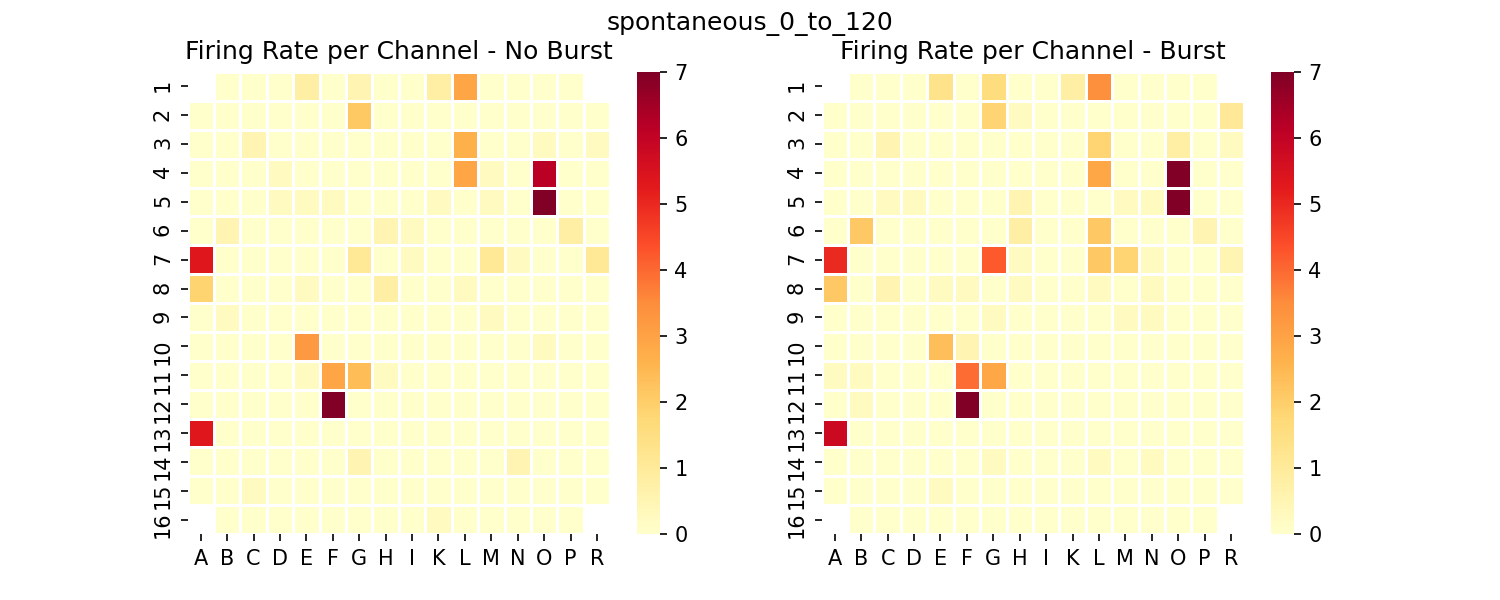

Text(0.5, 1.0, 'Firing Rate per Channel - Burst')

In [52]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

f.suptitle(filename)
sns.heatmap(df_fr_ibi, annot=False, linewidths=.5, ax=ax1, cmap="YlOrRd", vmax=7)
ax1.set_title('Firing Rate per Channel - No Burst')


sns.heatmap(df_fr_burst, annot=False, linewidths=.5, ax=ax2, cmap="YlOrRd", vmax=7)
ax2.set_title('Firing Rate per Channel - Burst')

#f.savefig(filename+'_MEA_Heatmap.png', dpi = 300)



In [53]:
df_fr_whole = get_dict_values(use_df_copy2, whole_recording_firingrate_dic)

In [54]:
df_fr_whole

A         B         C         D         E         F         G  \
1        NaN  0.000000  0.016667  0.000000  0.925000  0.000000  1.008333   
2   0.000000  0.008333  0.008333  0.000000  0.000000  0.000000  1.408333   
3   0.025000  0.025000  0.491667  0.008333  0.008333  0.025000  0.000000   
4   0.050000  0.025000  0.016667  0.025000  0.008333  0.016667  0.008333   
5   0.016667  0.000000  0.008333  0.033333  0.016667  0.050000  0.000000   
6   0.000000  1.425000  0.000000  0.000000  0.000000  0.041667  0.041667   
7   4.700000  0.016667  0.008333  0.008333  0.033333  0.175000  1.041667   
8   1.958333  0.008333  0.033333  0.008333  0.233333  0.075000  0.133333   
9   0.000000  0.083333  0.016667  0.025000  0.258333  0.016667  0.016667   
10  0.008333  0.000000  0.000000  0.000000  3.041667  0.533333  0.008333   
11  0.083333  0.041667  0.025000  0.058333  0.358333  3.783333  2.900000   
12  0.000000  0.008333  0.008333  0.241667  0.000000  8.241667  0.000000   
13  4.300000  0.008333  0.000000  0.108333  0.075000  0.108333  0.066667   
14  0.000000  0.016667  0.000000  0.066667  0.000000  0.083333  0.750000   
15  0.000000  0.000000  0.008333  0.008333  0.141667  0.016667  0.016667   
16       NaN  0.000000  0.016667  0.000000  0.000000  0.008333  0.008333   

           H         I         K         L         M         N         O  \
1   0.000000  0.008333  1.291667  3.033333  0.000000  0.166667  0.000000   
2   0.083333  0.016667  0.008333  0.000000  0.016667  0.000000  0.066667   
3   0.058333  0.025000  0.033333  2.508333  0.041667  0.308333  0.450000   
4   0.000000  0.008333  0.100000  2.916667  0.175000  0.025000  7.225000   
5   0.125000  0.008333  0.041667  0.008333  0.025000  0.008333  9.425000   
6   0.641667  0.033333  0.050000  1.100000  0.025000  0.091667  0.033333   
7   0.216667  0.025000  0.033333  0.858333  1.633333  0.166667  0.016667   
8   0.250000  0.091667  0.016667  0.675000  0.058333  0.125000  0.008333   
9   0.016667  0.000000  0.025000  0.025000  0.266667  0.016667  0.000000   
10  0.108333  0.008333  0.000000  0.008333  0.283333  0.008333  0.208333   
11  0.058333  0.000000  0.016667  0.000000  0.008333  0.025000  0.000000   
12  0.075000  0.000000  0.016667  0.000000  0.000000  0.000000  0.000000   
13  0.008333  0.000000  0.000000  0.008333  0.000000  0.000000  0.008333   
14  0.016667  0.000000  0.000000  0.016667  0.000000  0.066667  0.008333   
15  0.008333  0.000000  0.000000  0.000000  0.008333  0.008333  0.000000   
16  0.000000  0.000000  0.016667  0.016667  0.008333  0.000000  0.008333   

           P         R  
1   0.000000       NaN  
2   0.008333  0.841667  
3   0.000000  0.216667  
4   0.008333  0.008333  
5   0.008333  0.008333  
6   0.583333  0.000000  
7   0.008333  0.766667  
8   0.008333  0.000000  
9   0.050000  0.008333  
10  0.000000  0.000000  
11  0.008333  0.000000  
12  0.000000  0.008333  
13  0.008333  0.000000  
14  0.008333  0.016667  
15  0.000000  0.000000  
16  0.000000       NaN

In [55]:
df_fr_whole_normalized =(df_fr_whole-df_fr_whole.mean().max())/df_fr_whole.mean().std()

In [56]:
df_fr_whole_normalized

A         B         C         D         E          F         G  \
1         NaN -3.122752 -3.075054 -3.122752 -0.475493  -3.122752 -0.237001   
2   -3.122752 -3.098903 -3.098903 -3.122752 -3.122752  -3.122752  0.907759   
3   -3.051204 -3.051204 -1.715650 -3.098903 -3.098903  -3.051204 -3.122752   
4   -2.979657 -3.051204 -3.075054 -3.051204 -3.098903  -3.075054 -3.098903   
5   -3.075054 -3.122752 -3.098903 -3.027355 -3.075054  -2.979657 -3.122752   
6   -3.122752  0.955458 -3.122752 -3.122752 -3.122752  -3.003506 -3.003506   
7   10.328186 -3.075054 -3.098903 -3.098903 -3.027355  -2.621919 -0.141605   
8    2.481805 -3.098903 -3.027355 -3.098903 -2.454975  -2.908109 -2.741165   
9   -3.122752 -2.884260 -3.075054 -3.051204 -2.383427  -3.075054 -3.075054   
10  -3.098903 -3.122752 -3.122752 -3.122752  5.582199  -1.596404 -3.098903   
11  -2.884260 -3.003506 -3.051204 -2.955808 -2.097237   7.704776  5.176763   
12  -3.122752 -3.098903 -3.098903 -2.431126 -3.122752  20.464087 -3.122752   
13   9.183425 -3.098903 -3.122752 -2.812713 -2.908109  -2.812713 -2.931959   
14  -3.122752 -3.075054 -3.122752 -2.931959 -3.122752  -2.884260 -0.976326   
15  -3.122752 -3.122752 -3.098903 -3.098903 -2.717316  -3.075054 -3.075054   
16        NaN -3.122752 -3.075054 -3.122752 -3.122752  -3.098903 -3.098903   

           H         I         K         L         M         N          O  \
1  -3.122752 -3.098903  0.573871  5.558350 -3.122752 -2.645768  -3.122752   
2  -2.884260 -3.075054 -3.098903 -3.122752 -3.075054 -3.122752  -2.931959   
3  -2.955808 -3.051204 -3.027355  4.055851 -3.003506 -2.240332  -1.834896   
4  -3.122752 -3.098903 -2.836562  5.224461 -2.621919 -3.051204  17.554487   
5  -2.765014 -3.098903 -3.003506 -3.098903 -3.051204 -3.098903  23.850671   
6  -1.286365 -3.027355 -2.979657  0.025340 -3.051204 -2.860411  -3.027355   
7  -2.502673 -3.051204 -3.027355 -0.666286  1.551687 -2.645768  -3.075054   
8  -2.407277 -2.860411 -3.075054 -1.190968 -2.955808 -2.765014  -3.098903   
9  -3.075054 -3.122752 -3.051204 -3.051204 -2.359578 -3.075054  -3.122752   
10 -2.812713 -3.098903 -3.122752 -3.098903 -2.311880 -3.098903  -2.526523   
11 -2.955808 -3.122752 -3.075054 -3.122752 -3.098903 -3.051204  -3.122752   
12 -2.908109 -3.122752 -3.075054 -3.122752 -3.122752 -3.122752  -3.122752   
13 -3.098903 -3.122752 -3.122752 -3.098903 -3.122752 -3.122752  -3.098903   
14 -3.075054 -3.122752 -3.122752 -3.075054 -3.122752 -2.931959  -3.098903   
15 -3.098903 -3.122752 -3.122752 -3.122752 -3.098903 -3.098903  -3.122752   
16 -3.122752 -3.122752 -3.075054 -3.075054 -3.098903 -3.122752  -3.098903   

           P         R  
1  -3.122752       NaN  
2  -3.098903 -0.713985  
3  -3.122752 -2.502673  
4  -3.098903 -3.098903  
5  -3.098903 -3.098903  
6  -1.453309 -3.122752  
7  -3.098903 -0.928627  
8  -3.098903 -3.122752  
9  -2.979657 -3.098903  
10 -3.122752 -3.122752  
11 -3.098903 -3.122752  
12 -3.122752 -3.098903  
13 -3.098903 -3.122752  
14 -3.098903 -3.075054  
15 -3.122752 -3.122752  
16 -3.122752       NaN

In [57]:
mean_fr_whole_recording

76.175

<IPython.core.display.Javascript object>


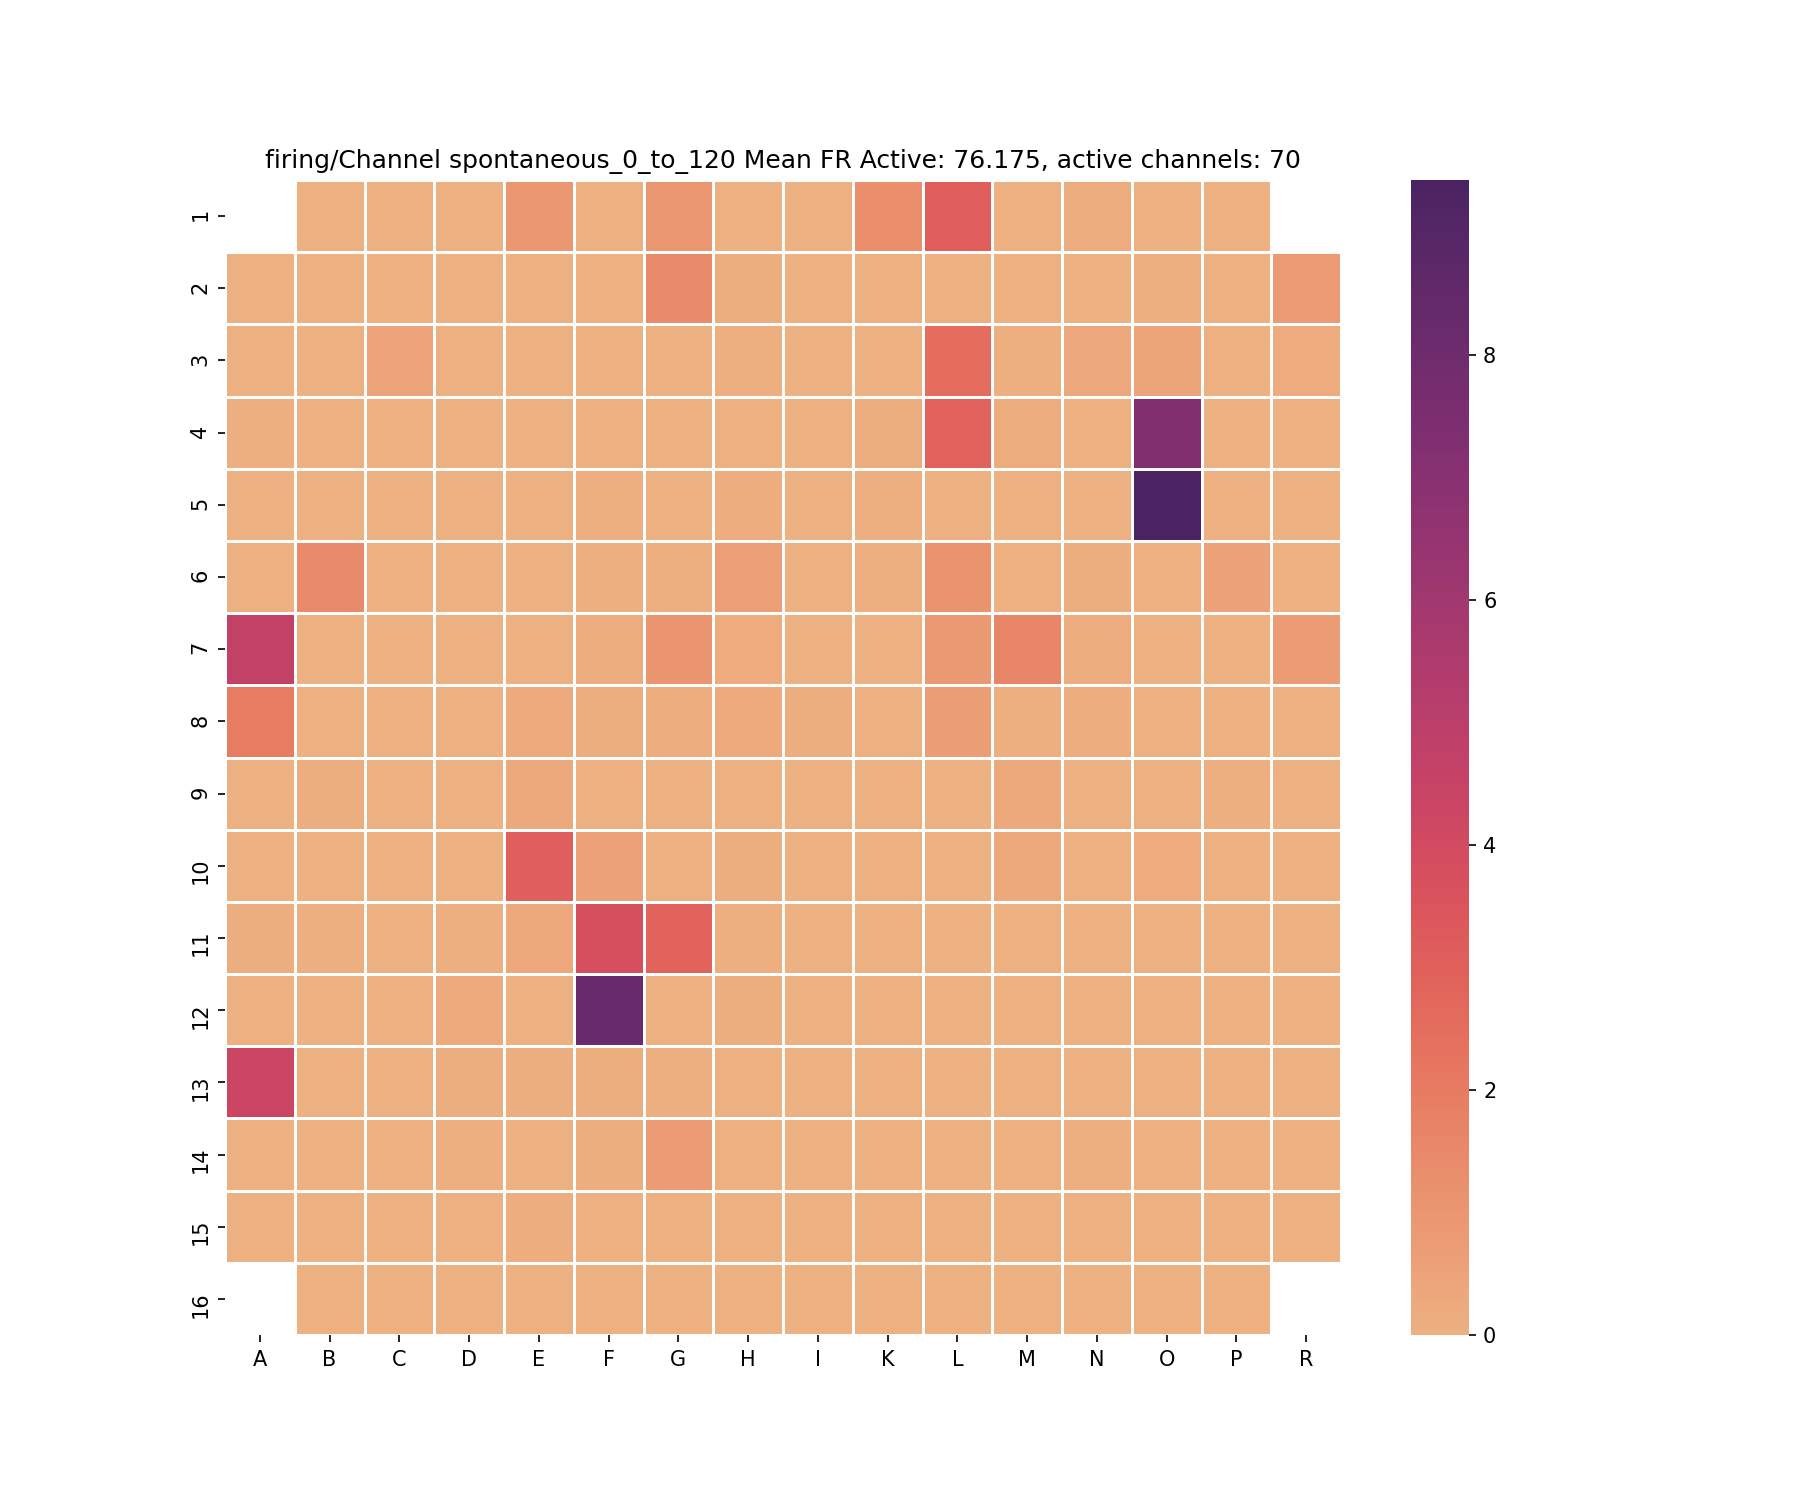

Text(0.5, 1.0, 'firing/Channel spontaneous_0_to_120 Mean FR Active: 76.175, active channels: 70')

In [58]:
f, ax = plt.subplots(1, 1, figsize = (12,10))

sns.heatmap(df_fr_whole, annot=False, linewidths=.5, ax=ax, cmap="flare")
ax.set_title('firing/Channel ' + filename + ' Mean FR Active: {}, active channels: {}'.format(mean_fr_whole_recording, active_channels))

#f.savefig(filename+'whole_MEA_Heatmap.png', dpi = 300, bbox_inches = 'tight')

<IPython.core.display.Javascript object>


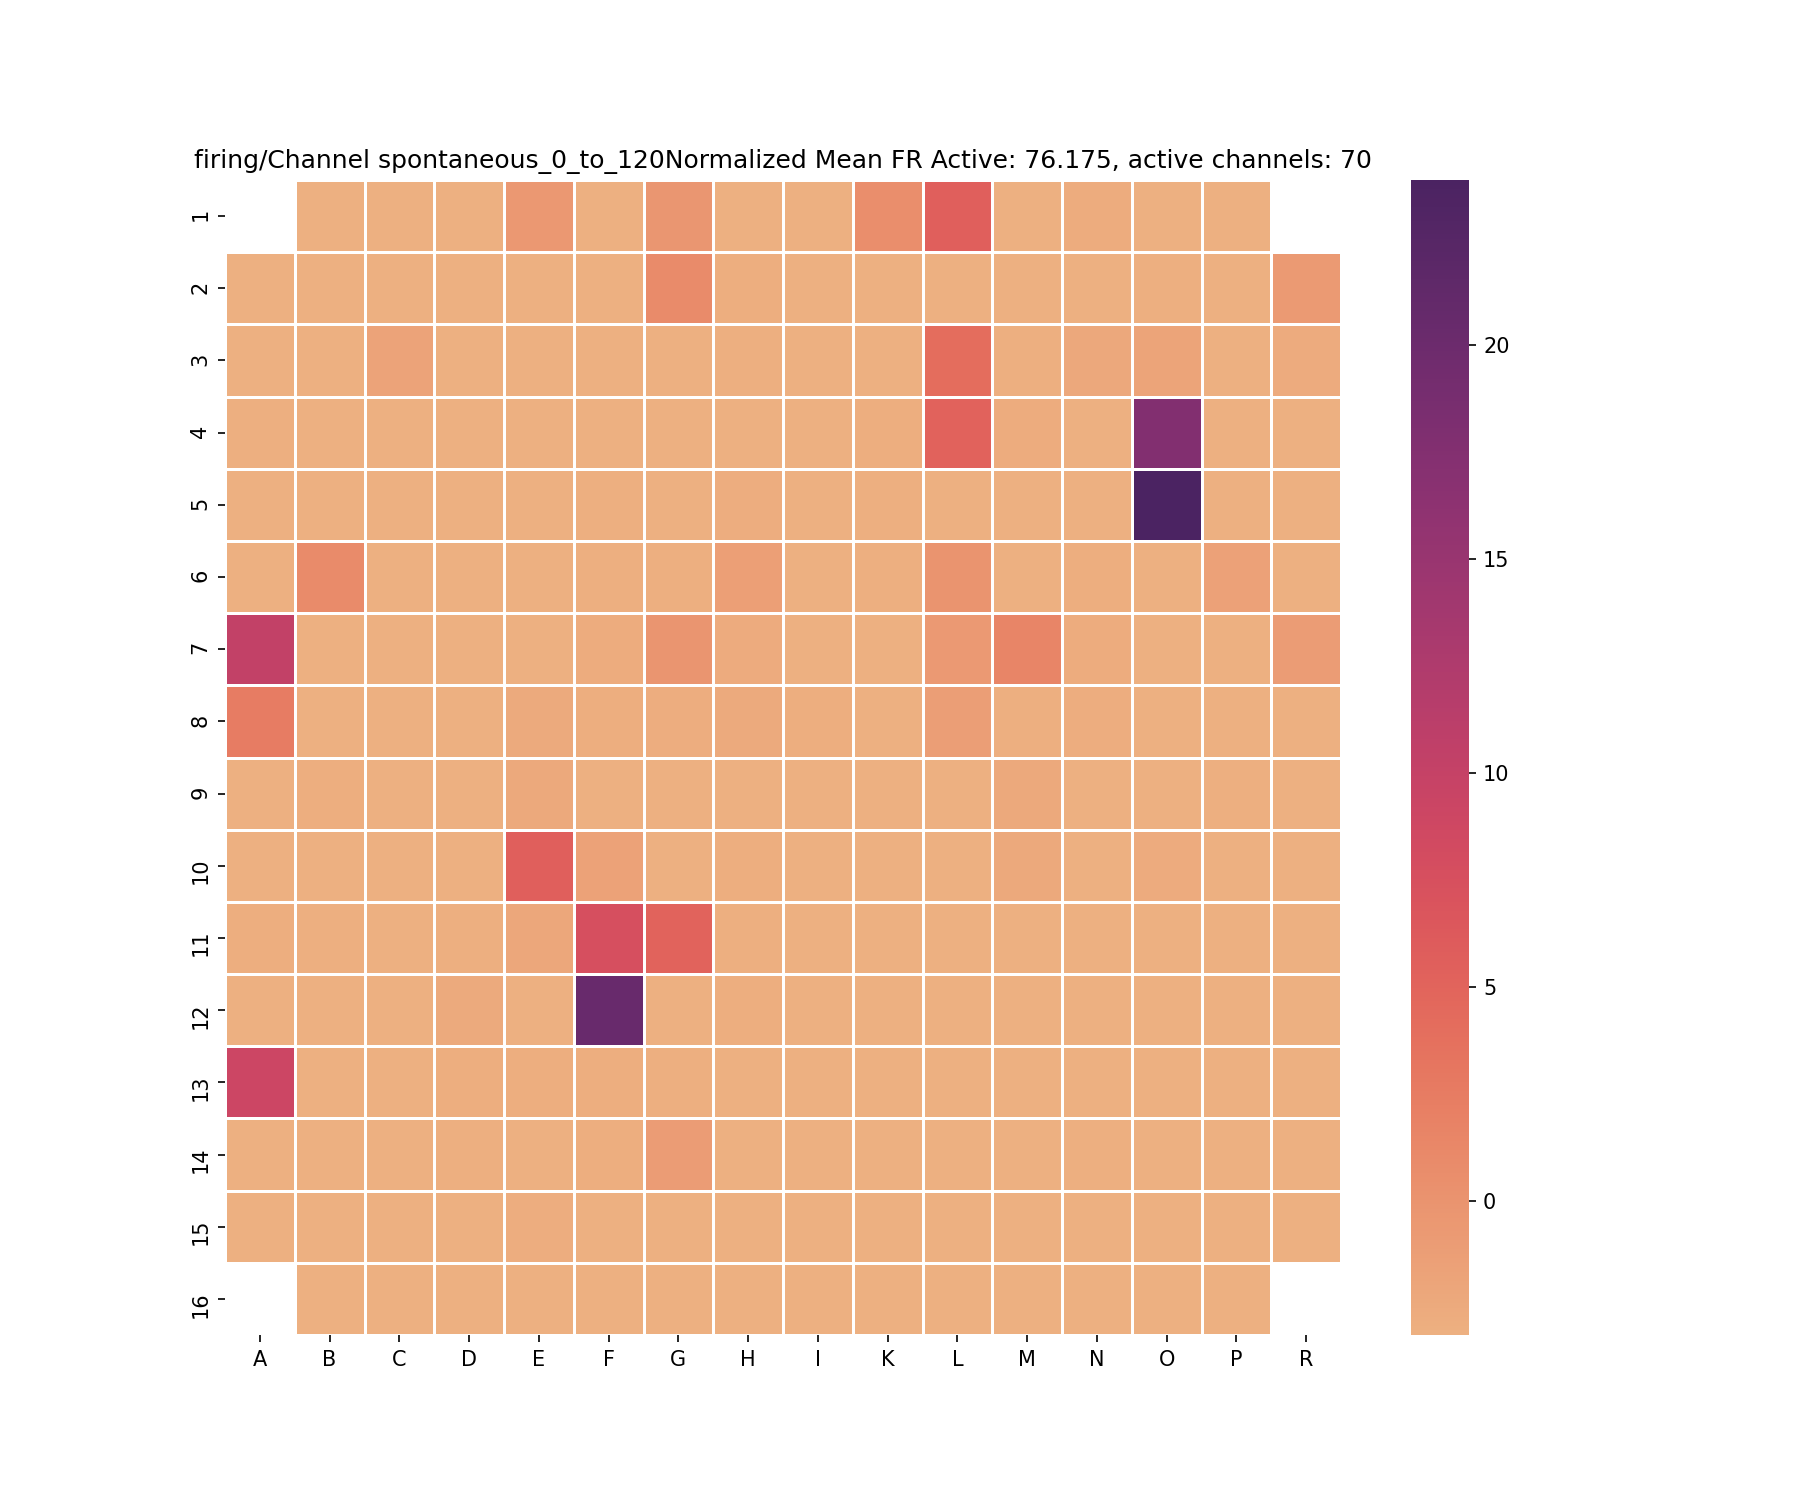

Text(0.5, 1.0, 'firing/Channel spontaneous_0_to_120Normalized Mean FR Active: 76.175, active channels: 70')

In [59]:
f, ax = plt.subplots(1, 1, figsize = (12,10))

sns.heatmap(df_fr_whole_normalized, annot=False, linewidths=.5, ax=ax, cmap="flare")
ax.set_title('firing/Channel ' + filename + 'Normalized Mean FR Active: {}, active channels: {}'.format(mean_fr_whole_recording, active_channels))

#f.savefig(filename+'whole_MEA_Heatmap_normalized.png', dpi = 300, bbox_inches = 'tight')



In many recordings, we do not find the typical network activity but rather single bursting channels. For these it must be evaluated if a split of the recordings into is feasible. 

The burst and non burst parts can be saved using pickle. Uncross if you want to save them, e.g. for SPADE Analysis.

In [60]:
#np.save(filename+'sub_recording_BURST.npy', st_longest_burst)
#np.save(filename+'sub_recording_NON-BURST.npy', st_longest_ibi)

In [61]:
filename

'spontaneous_0_to_120'

In [62]:
longest_burst_i

(113.62949447273029, 117.4282430582059)

# Subdivision of a Burst of Interest

In the next part we take a Network Burst and plot it on a small scale to see how the spikes develop. 

Further, we will divide it in 200ms parts to see how the spikes will develop temporarily over the MEA Grid.

<IPython.core.display.Javascript object>


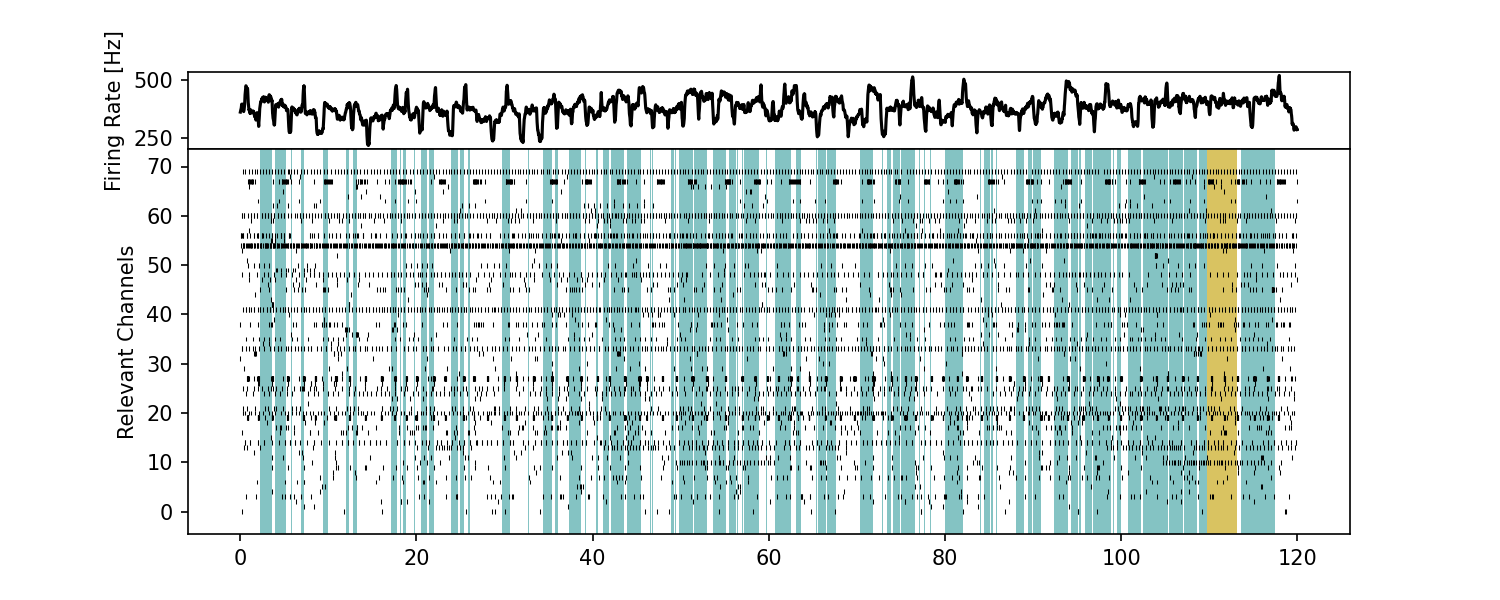

In [63]:
# we plot the beginning figure -> burst of interest is in yellow

# we choose the burst we want to plot and get start and end time in seconds
burst_of_interest = -5
b_of_interest_start = burst_seconds_start[burst_of_interest]
b_of_interest_end = burst_seconds_end[burst_of_interest]



fig = plt.figure(figsize = (10,4))
gs = fig.add_gridspec(2, hspace = 0, height_ratios=[1,5])
axs = gs.subplots(sharex=False, sharey=False)
axs[0].plot(ma_fr_gau, color= 'black')
axs[0].set_ylabel('Firing Rate [Hz]')
axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.5, linelengths = 1)
axs[1].set_ylabel('Relevant Channels')

for ax in axs:
    for i in bursts_seconds:
        axs[1].axvspan(i[0], i[1], facecolor = '#118C8C', alpha = 0.3)
        
        axs[1].axvspan(b_of_interest_start, 
                       b_of_interest_end, facecolor = '#F2CD5E', alpha = 0.2, 
                       label = 'longest network burst'
                      )
        
fig.savefig(filename+'_raster_and_FR_plot_09082021.png', dpi=300, bbox_inches = 'tight')

In [64]:
# in the spikearray_seconds we have every spike used in the whole recording block
# we will now filter them to be in the time region of interest and create burst_of_interest_array

boi_array = []

for i in spikearray_seconds:
    channel_array_list = []
    for j in i:
        if (j >= b_of_interest_start) and (j <= b_of_interest_end):
            channel_array_list.append(j)
    channel_array = np.asarray(channel_array_list)
    boi_array.append(channel_array)

boi_array = np.asarray(boi_array)

<IPython.core.display.Javascript object>


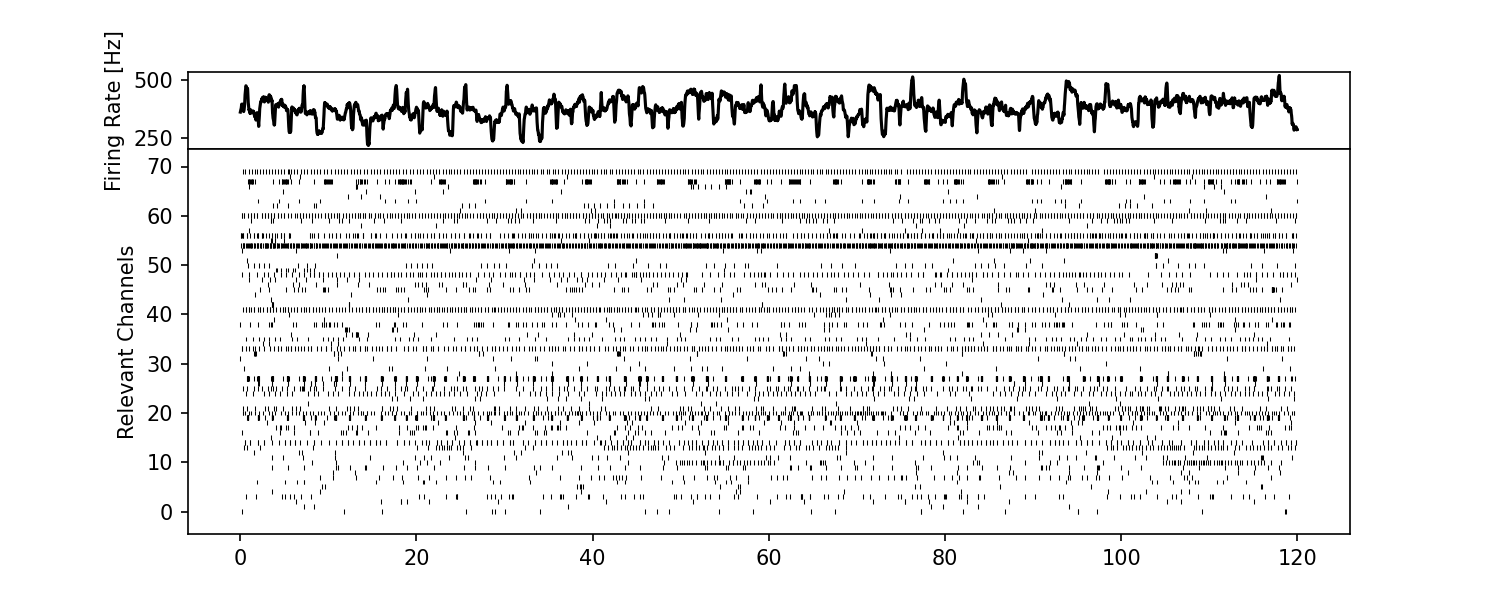

Text(0, 0.5, 'Relevant Channels')

In [65]:
# we can plot this subpart of the array

fig = plt.figure(figsize = (10,4))
gs = fig.add_gridspec(2, hspace = 0, height_ratios=[1,5])
axs = gs.subplots(sharex=False, sharey=False)
axs[0].plot(ma_fr_gau, color= 'black')
axs[0].set_ylabel('Firing Rate [Hz]')
axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.5, linelengths = 1)
axs[1].set_ylabel('Relevant Channels')


<IPython.core.display.Javascript object>


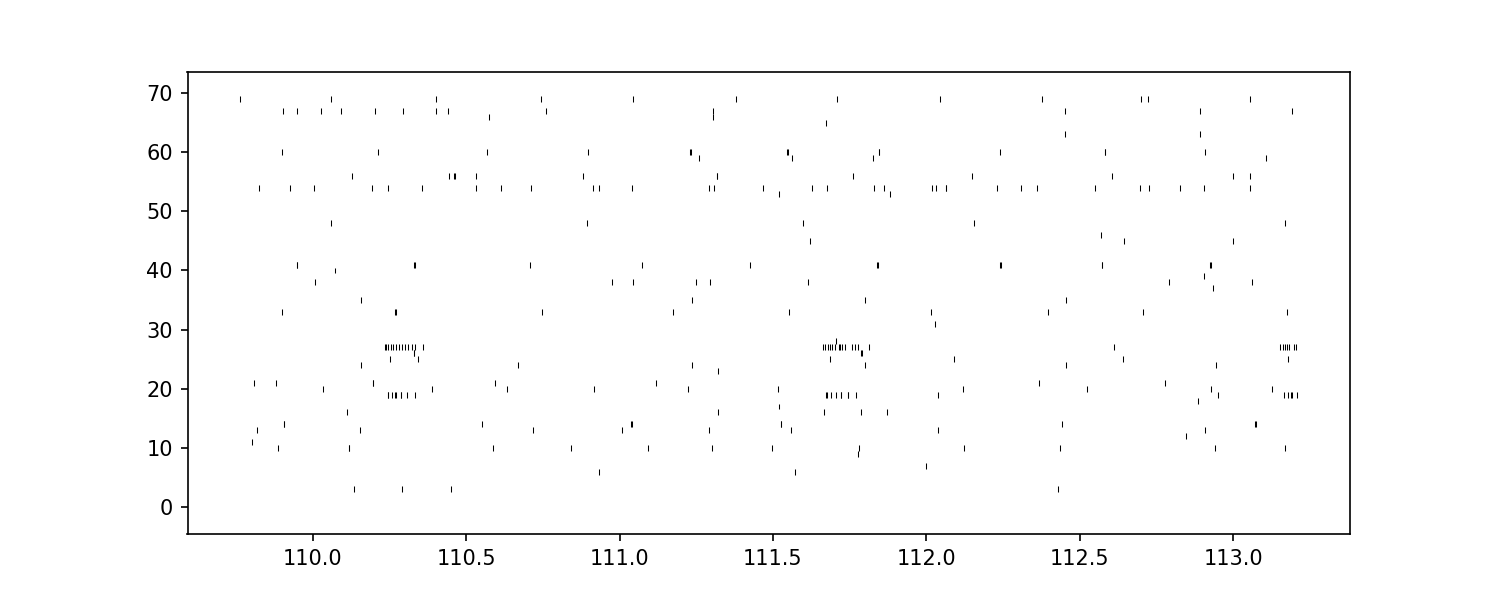

In [66]:
fig, ax = plt.subplots(1, 1, figsize = (10,4))

ax = plt.eventplot(boi_array, color = 'black', linewidths = 0.5, linelengths= 1)

In [67]:
# we use the subdivide function to get the st of the burst of interest

st_burst_of_interest = subdivide_spiketrain(spikedic_MAD, b_of_interest_start, b_of_interest_end)

In [68]:
# we now want to make heatmaps to picture the activity to observe the spatial propagation

# define how much time of the st you want to observe
heatmap_window = 0.2 # in seconds


# make start and endpoints for each of these time-windows:
time_windows = []

# start of the subdivision = rounded start of the burst of interest
i = np.round(b_of_interest_start, 4)

# for every iteration, add the desired heatmap window
while i < b_of_interest_end:
    start = i
    stop = np.round(i+heatmap_window, 4)
    i = i + heatmap_window 
    if stop > b_of_interest_end:
        stop = b_of_interest_end
    time_windows.append((start, stop))
    
time_windows = time_windows[:10]


In [69]:
b_of_interest_start

109.74077552601975

In [70]:
time_windows

[(109.7408, 109.9408),
 (109.9408, 110.1408),
 (110.1408, 110.3408),
 (110.3408, 110.5408),
 (110.5408, 110.7408),
 (110.74080000000001, 110.9408),
 (110.94080000000001, 111.1408),
 (111.14080000000001, 111.3408),
 (111.34080000000002, 111.5408),
 (111.54080000000002, 111.7408)]

<IPython.core.display.Javascript object>


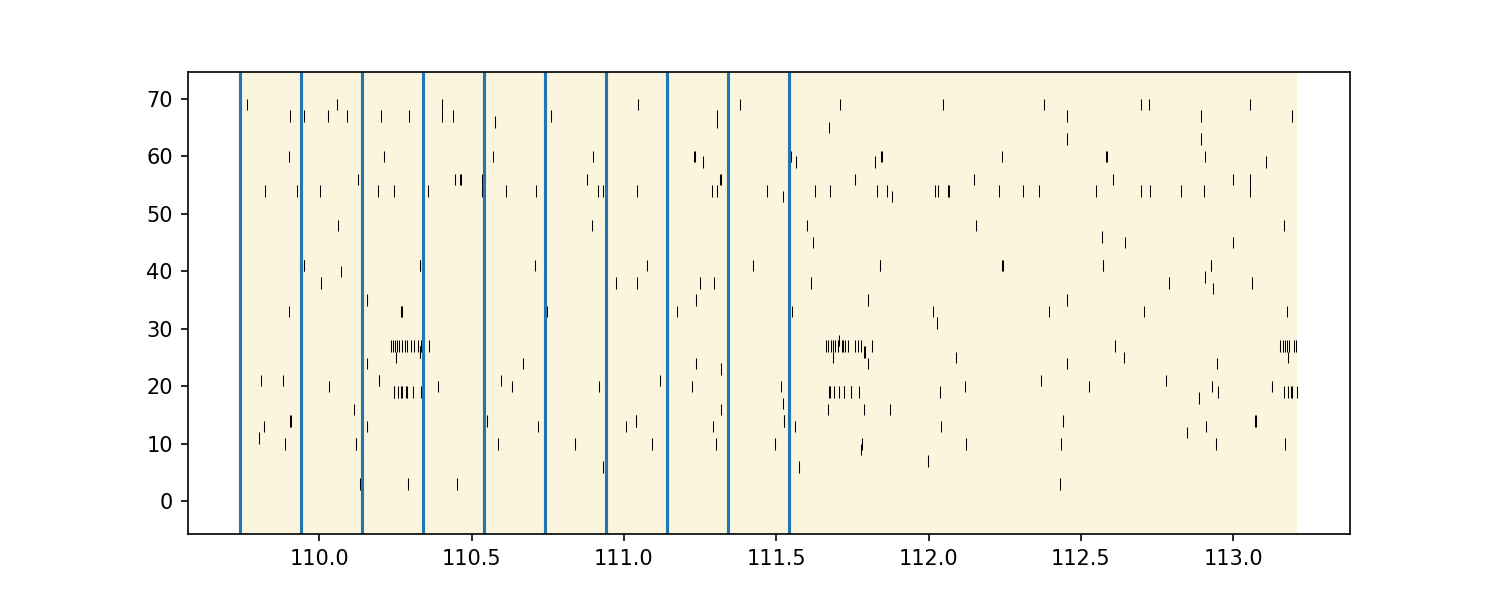

In [71]:
fig, ax = plt.subplots(1, 1, figsize = (10,4))

ax = plt.eventplot(boi_array, color = 'black', linewidths = 0.5, linelengths= 2)
ax = plt.axvspan(b_of_interest_start, 
                       b_of_interest_end, facecolor = '#F2CD5E', alpha = 0.2, 
                       label = 'longest network burst'
                      )

# plot the lines for the subdivisions
for i in time_windows:
    ax = plt.axvline(i[0])
    
    
#fig.savefig(filename + '_interesting_burst_16082021.png', dpi=300, bbox_inches = 'tight')


In [72]:
# we can now
len(time_windows)

10

In [73]:
# we will now create a dictionary with key = starts of the subdivision
# and values = dictionary  of the corresponding spiketrains

subdivided_boi_st = {}
subdivided_boi_fr = {}

for i in time_windows:
    #empty dic for firing rates
    fr_subs = {}
    
    # get the spiketrains for the time subpart
    st = subdivide_spiketrain(spikedic_MAD, i[0], i[1])
    
    # assign the subdivided dictionary to the subdivision dictionary
    subdivided_boi_st[i[0]] = st
    
    # for firing rate, we calculate the fr for each channel
    for key in st:
        fr = len(st[key]) / (i[1]-i[0])
        
        #assign the firing rate to that key
        fr_subs[key] = fr
     
    # the value for the subdivision key is that used subdic, which is emptied in the next loop
    subdivided_boi_fr[i[0]] = fr_subs
        
    
    

In [74]:
# how many subplots we want to create
number_of_heatmaps = len(time_windows)

number_columns = int(number_of_heatmaps / 2)




In [75]:
# for plotting with sns heatmap we need a df first 

# this is done as empty df:

mea_array=np.empty((16,16,))
mea_array[:]=np.nan
columnlist =['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','R']
df = pd.DataFrame(data=mea_array,columns=columnlist)
df.index+=1


In [76]:
df

A   B   C   D   E   F   G   H   I   K   L   M   N   O   P   R
1  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
3  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
4  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
5  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
6  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
7  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
8  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
9  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
10 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
11 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
12 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
13 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
14 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
15 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
16 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN

<IPython.core.display.Javascript object>


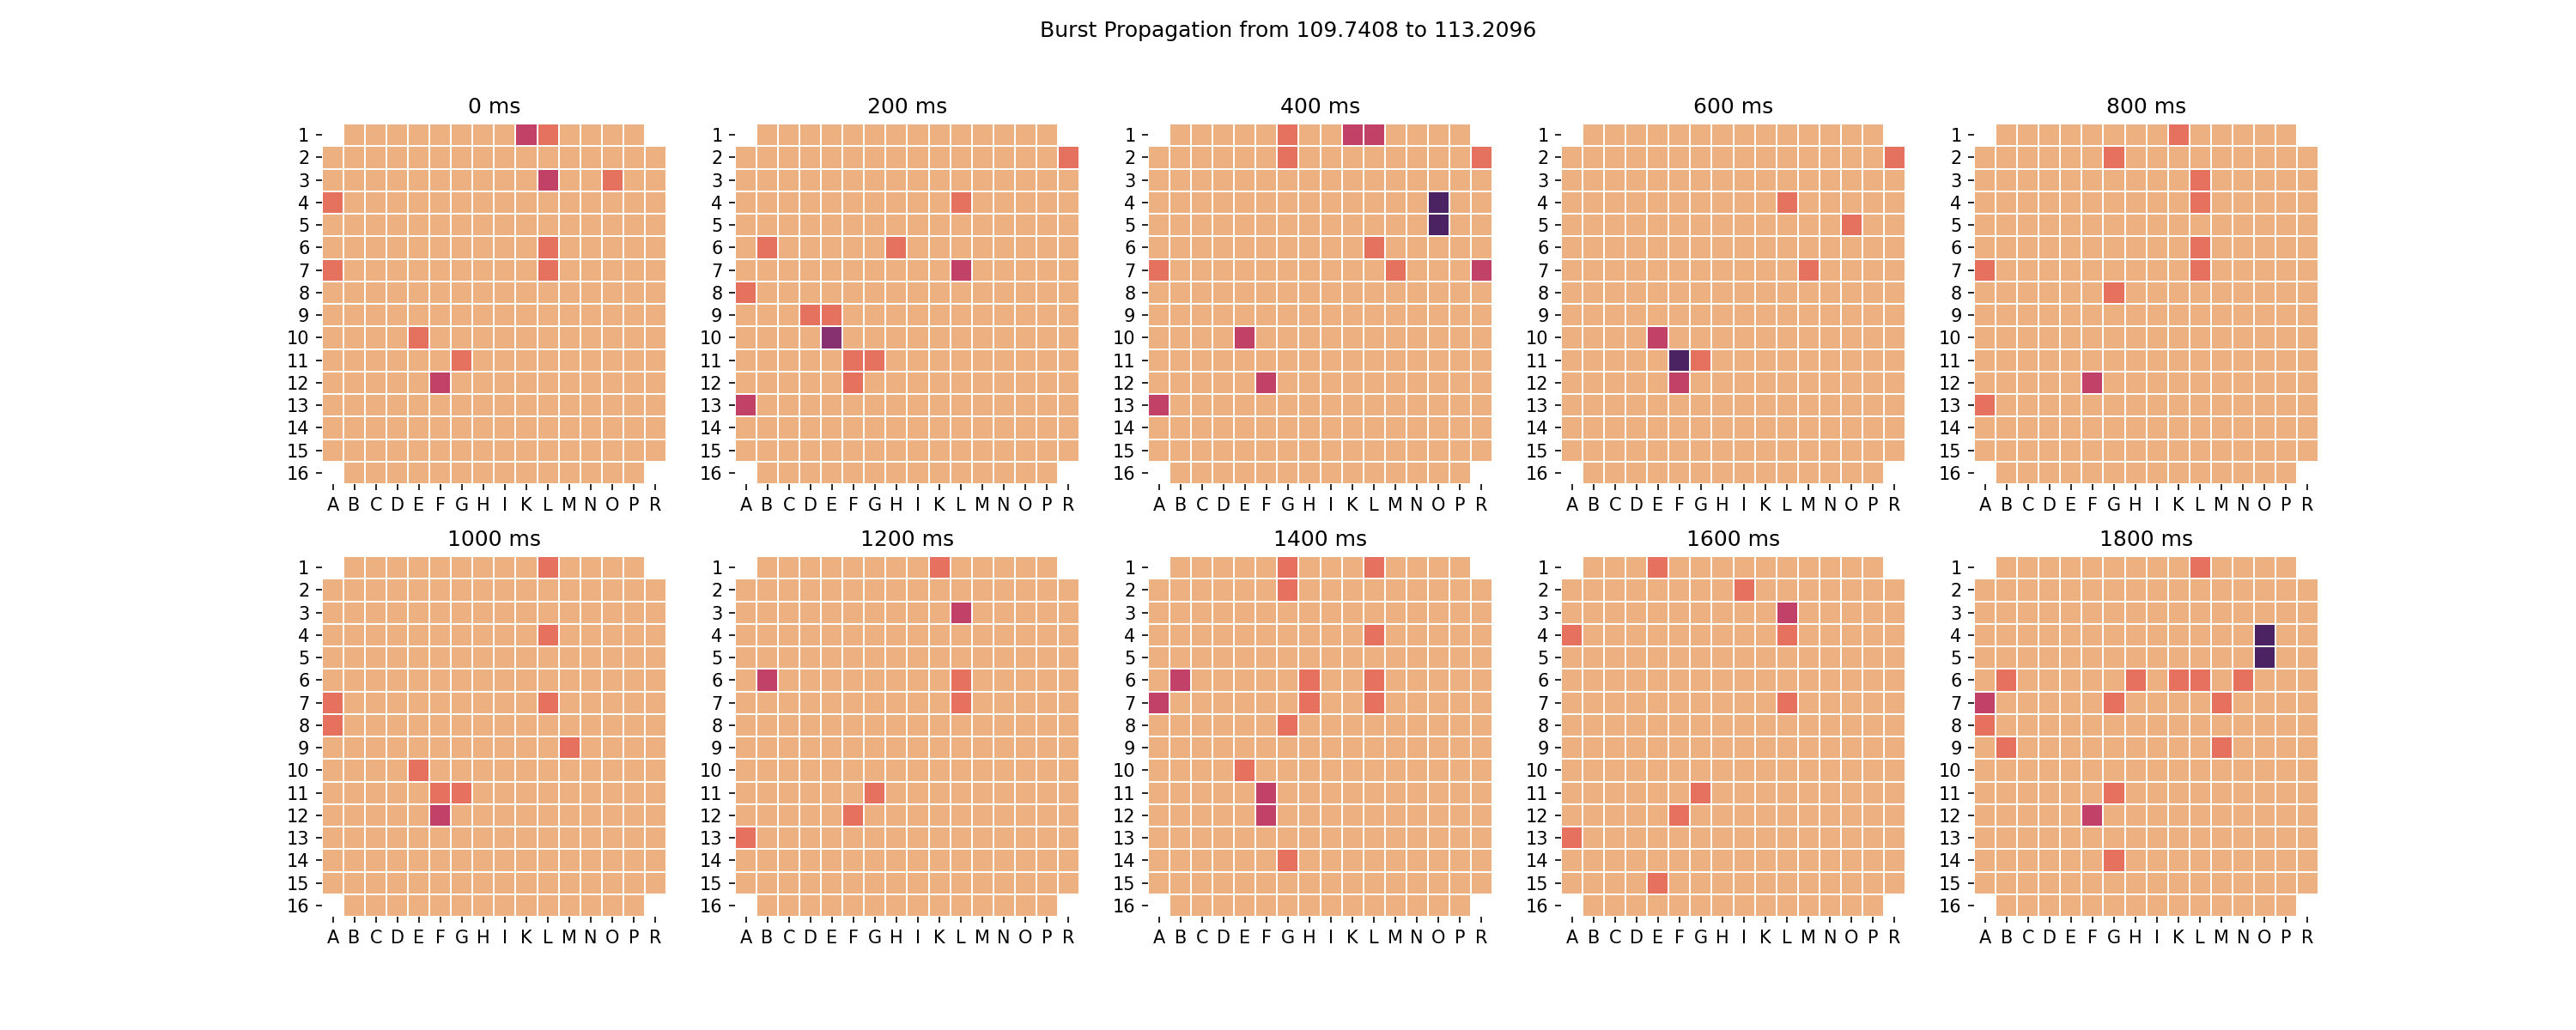

In [77]:
fig = plt.figure(figsize=(20,8))

fig.tight_layout()
fig.suptitle('Burst Propagation from ' + 
             str(np.round(b_of_interest_start, 4))+ ' to ' + 
             str(np.round(b_of_interest_end, 4)))
gs1 = gridspec.GridSpec(2, 5)

#countries = ["Country " + str(i) for i in range(1, 26)]
axs = []
time_intra_burst = 0

for i in range(1, len(time_windows)+1):
    

    plotframe = copy.deepcopy(df)
    
    # get the key for the fr_dic from the time windows:
    key = time_windows[i-1][0] # substract one because we start the for range at 1
    
    #extract the corresponding fr_dic
    fr_dic = subdivided_boi_fr[key]
    
    # fill the dataframe
    plotframe_filled = get_dict_values(plotframe, fr_dic)
    #plotframe_filled = plotframe_filled.fillna(0)
    
    axs.append(fig.add_subplot(gs1[i-1]))
    # plot the heatmap
    #sns.heatmap(plotframe_filled, annot=False, linewidths=.5, ax=axstring, cmap="YlOrRd")


    axs[-1] = sns.heatmap(plotframe_filled, 
                          annot=False, vmin=0, vmax = 20, cmap='flare', 
                          cbar = False, linewidths=0.1)
    
    
    plt.setp(axs[-1], 
             title=str(int(time_intra_burst)) + ' ms')
    
    time_intra_burst += (heatmap_window*1000)

#fig.savefig(filename+'_divided_burst_spatial_09082021.png', dpi=300, bbox_inches = 'tight')



## we can try what happens if we zoom in further

In [78]:
b_of_interest_start = 110.1
b_of_interest_end = 111

<IPython.core.display.Javascript object>


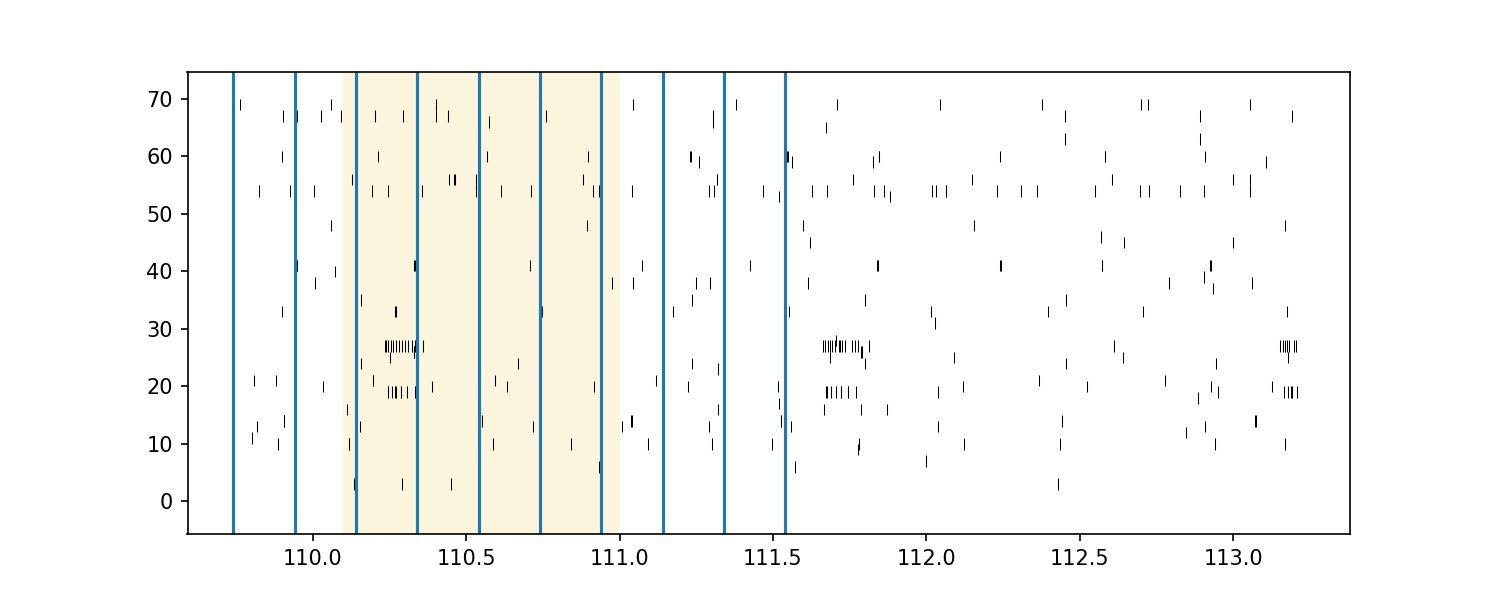

In [79]:
fig, ax = plt.subplots(1, 1, figsize = (10,4))

ax = plt.eventplot(boi_array, color = 'black', linewidths = 0.5, linelengths= 2)
ax = plt.axvspan(b_of_interest_start, 
                       b_of_interest_end, facecolor = '#F2CD5E', alpha = 0.2, 
                       label = 'longest network burst'
                      )

# plot the lines for the subdivisions
for i in time_windows:
    ax = plt.axvline(i[0])
    
    
fig.savefig(filename + '_interesting_burst_09082021_zooming.png', dpi=300, bbox_inches = 'tight')

In [81]:
# we now want to make heatmaps to picture the activity to observe the spatial propagation

# let us make the heatmap window generic, so the burst is always subdivied into 10 subplots
observed_time = b_of_interest_end-b_of_interest_start

heatmap_window = observed_time/10 # in seconds

# make start and endpoints for each of these time-windows:

time_windows = []

# start of the subdivision = rounded start of the burst of interest
i = np.round(b_of_interest_start, 4)

# for every iteration, add the desired heatmap window
while i < b_of_interest_end:
    start = i
    stop = np.round(i+heatmap_window, 4)
    i = i + heatmap_window 
    if stop > b_of_interest_end:
        stop = b_of_interest_end
    time_windows.append((start, stop))

time_windows = time_windows[:10]

In [82]:
len(time_windows)

10

In [83]:
# we again obtain the array of that burst
# in the spikearray_seconds we have every spike used in the whole recording block
# we will now filter them to be in the time region of interest and create burst_of_interest_array

boi_array = []

for i in spikearray_seconds:
    channel_array_list = []
    for j in i:
        if (j >= b_of_interest_start) and (j <= b_of_interest_end):
            channel_array_list.append(j)
    channel_array = np.asarray(channel_array_list)
    boi_array.append(channel_array)

boi_array = np.asarray(boi_array)

In [84]:
b_of_interest_end

111

<IPython.core.display.Javascript object>


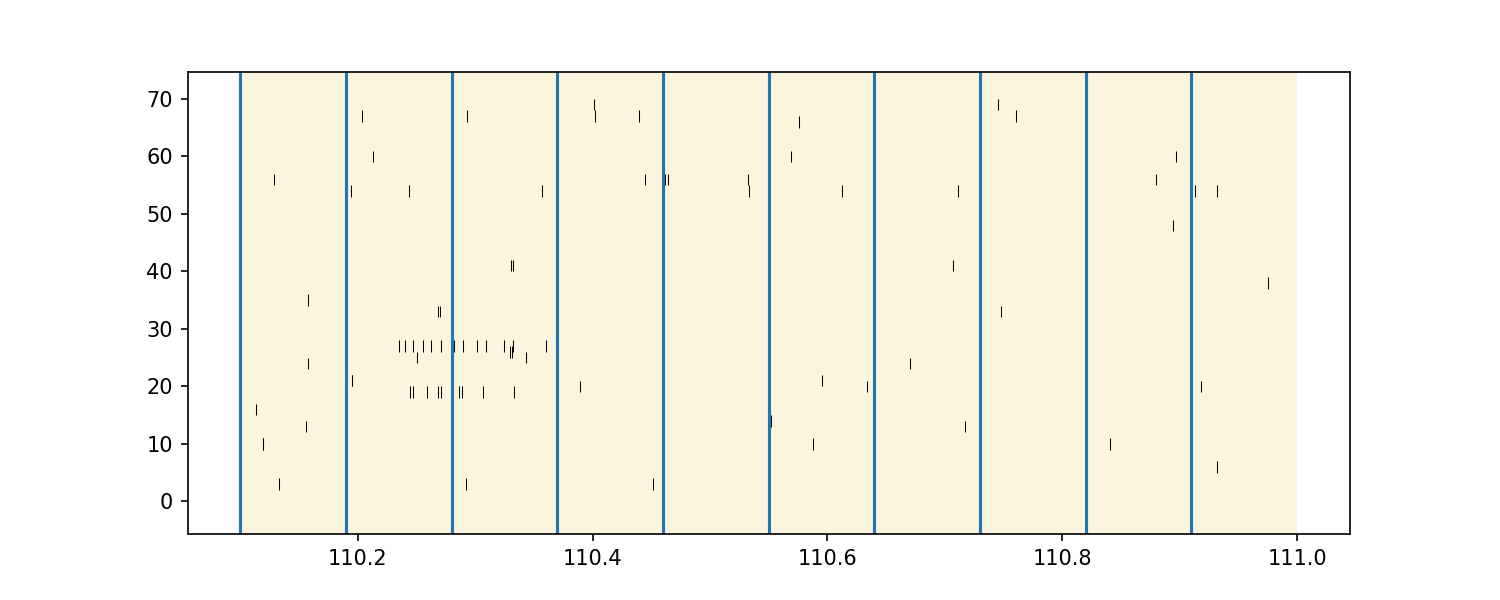

In [85]:
fig, ax = plt.subplots(1, 1, figsize = (10,4))

ax = plt.eventplot(boi_array, color = 'black', linewidths = 0.5, linelengths= 2)
ax = plt.axvspan(b_of_interest_start, 
                       b_of_interest_end, facecolor = '#F2CD5E', alpha = 0.2, 
                       label = 'longest network burst'
                      )

# plot the lines for the subdivisions
for i in time_windows:
    ax = plt.axvline(i[0])
    
    
fig.savefig(filename + '_interesting_burst_zoomed_09082021.png', dpi=300, bbox_inches = 'tight')

In [87]:
# we will now create a dictionary with key = starts of the subdivision
# and values = dictionary  of the corresponding spiketrains

subdivided_boi_st = {}
subdivided_boi_fr = {}

for i in time_windows:
    #empty dic for firing rates
    fr_subs = {}
    
    # get the spiketrains for the time subpart
    st = subdivide_spiketrain(spikedic_MAD, i[0], i[1])
    
    # assign the subdivided dictionary to the subdivision dictionary
    subdivided_boi_st[i[0]] = st
    
    # for firing rate, we calculate the fr for each channel
    for key in st:
        fr = len(st[key]) / (i[1]-i[0])
        
        #assign the firing rate to that key
        fr_subs[key] = fr
     
    # the value for the subdivision key is that used subdic, which is emptied in the next loop
    subdivided_boi_fr[i[0]] = fr_subs
        

<IPython.core.display.Javascript object>


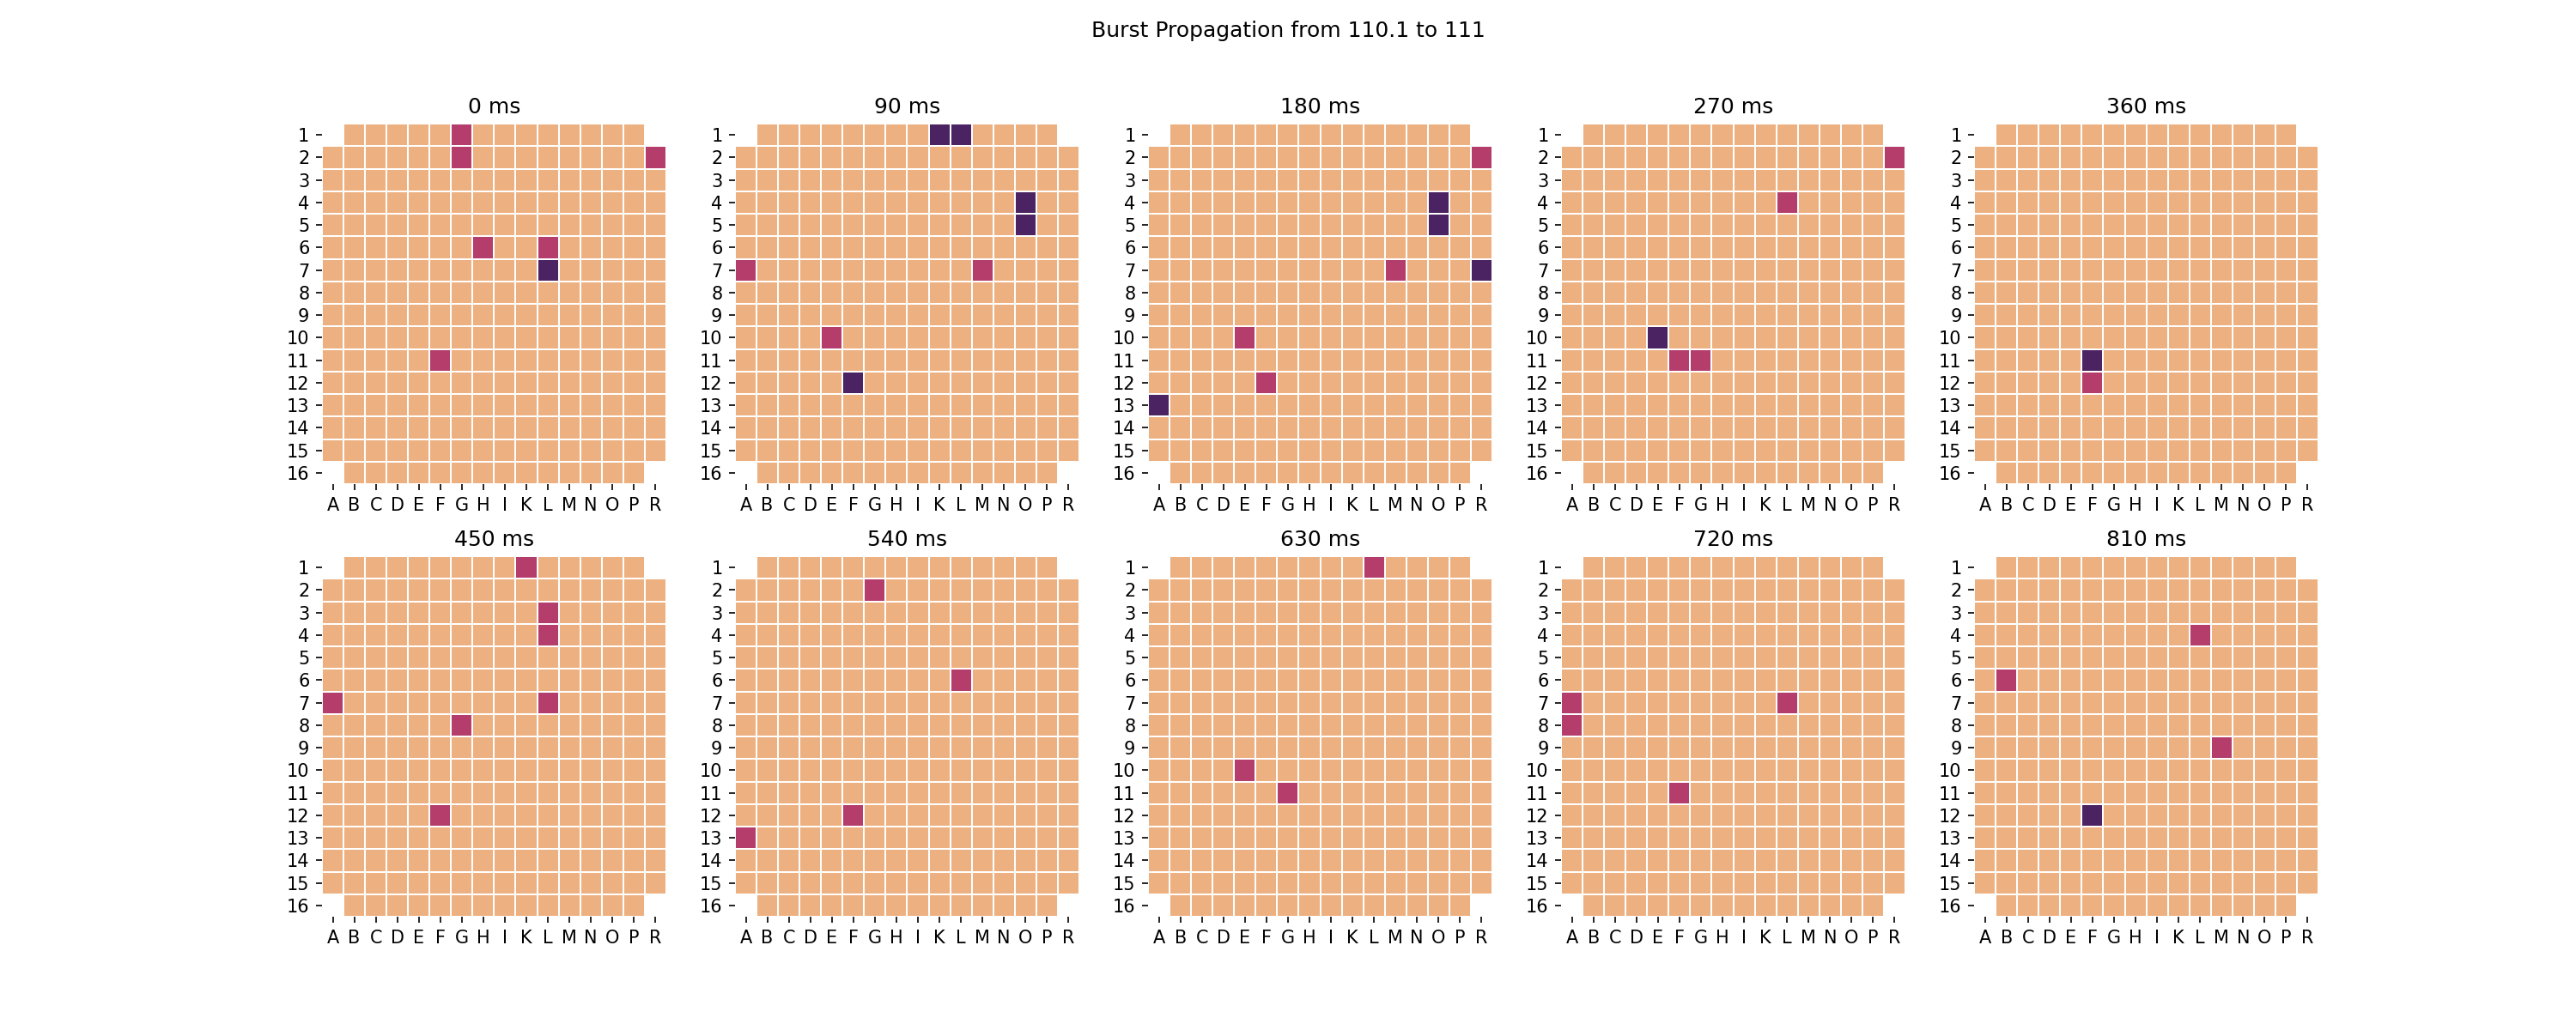

In [88]:
fig = plt.figure(figsize=(20,8))

fig.tight_layout()
fig.suptitle('Burst Propagation from ' + 
             str(np.round(b_of_interest_start, 4))+ ' to ' + 
             str(np.round(b_of_interest_end, 4)))
gs1 = gridspec.GridSpec(2, 5)

#countries = ["Country " + str(i) for i in range(1, 26)]
axs = []
time_intra_burst = 0

for i in range(1, len(time_windows)+1):
    

    plotframe = copy.deepcopy(df)
    
    # get the key for the fr_dic from the time windows:
    key = time_windows[i-1][0] # substract one because we start the for range at 1
    
    #extract the corresponding fr_dic
    fr_dic = subdivided_boi_fr[key]
    
    # fill the dataframe
    plotframe_filled = get_dict_values(plotframe, fr_dic)
    
    axs.append(fig.add_subplot(gs1[i-1]))
    # plot the heatmap
    #sns.heatmap(plotframe_filled, annot=False, linewidths=.5, ax=axstring, cmap="YlOrRd")


    axs[-1] = sns.heatmap(plotframe_filled, 
                          annot=False, vmin=0, vmax = 20, cmap='flare', 
                          cbar = False, linewidths=0.1)
    
    
    plt.setp(axs[-1], 
             title=str(int(time_intra_burst)) + ' ms')
    
    time_intra_burst += (heatmap_window*1000)

fig.savefig(filename +'_divided_burst_spatial_zoomed_09082021.png', dpi=300, bbox_inches = 'tight')

## Join a Subdivied Recording and prepare the analysis for the whole Recordings

Since threshold extraction of spikes is computationally extensive, we subidivided the original recording into two minute sets. We now want to rejoin these two minute sets and repeat the analysis as above:



In [89]:
filename = 'filename_completerecording'

In [90]:
infodic

timelengthrecording_s = info_dic['timelengthrecording_s']

In [91]:
info_dic

{'tick': 40,
 'timelengthrecording_s': 1200.0,
 'first_recording_timepoint': 0,
 'scale_factor_for_second': 1e-06,
 'network_burst_threshold_basline': 45.15558946967146}

The spikedics we use are already containting spikes in the original tick value.
That means for the subdivided dictionaries the spiketrains don't start at zero again but when the subdivided dictionary starts.

In [92]:
timekeys = list(spikedics.keys())
channelkeys = list(spikedics[timekeys[0]].keys())

In [93]:
# we now need to use a double loop to get all dictionary keys and join them into a big full recording dictionary

spikedic_MAD_full = {}
temp_spikelist = []

for i in channelkeys:
    temp_spikelist = []
    for j in timekeys:
        spikes = list(spikedics[j][i])
        temp_spikelist.append(spikes)
    
    #join the lists
    temp_spikelista = sum(temp_spikelist, [])
    #remove the duplicates
    temp_spikelistb = list(set(temp_spikelista))
    
    #sort the list
    temp_spikelistc = sorted(temp_spikelistb)
    
    #assign them to their channel in the full dictionary
    spikedic_MAD_full[i] = temp_spikelistc

        

In [94]:
spikedic_MAD = spikedic_MAD_full

In [95]:
np.save(filename +'_full_spikedic.npy', spikedic_MAD_full)

Now the analysis can proceed just as before for the longer recording

In [96]:
 # create an array of the spikes in scale of seconds
active_channels = 0
spikedic_seconds = {}
for key in spikedic_MAD:
    relevant_factor = timelengthrecording_s*0.05
    if len(spikedic_MAD[key])>relevant_factor:
        sec_array = np.asarray(spikedic_MAD[key])*tick*scale_factor_for_second
        spikedic_seconds[key]=sec_array
        active_channels += 1
spikearray_seconds = np.asarray(list(spikedic_seconds.values()))  

In [97]:
active_channels

79

In [98]:
# get a 1-D array with every detected spike
scale_factor_for_milisecond = 1e-03
full_spike_list = []
full_spike_list_seconds = []
for key in spikedic_MAD:
    if len(spikedic_MAD[key])>relevant_factor:
        x = list(np.asarray(spikedic_MAD[key])*scale_factor_for_milisecond*tick)
        full_spike_list = full_spike_list + x

        xs = list(np.asarray(spikedic_MAD[key])*scale_factor_for_second*tick)
        full_spike_list_seconds = full_spike_list_seconds + xs
full_spikes = sorted(full_spike_list)
full_spikes_seconds = sorted(full_spike_list_seconds)

In [99]:
mean_fr_whole_recording = np.around((len(full_spikes_seconds) / timelengthrecording_s), 3)

In [100]:
mean_fr_whole_recording

90.166

In [101]:
#define bins 
binsize = 0.005 #seconds
bins= np.arange(0, timelengthrecording_s+binsize, binsize)

# make a histogram 
full_spikes_binned = np.histogram(full_spikes_seconds, bins)[0]


#trial of population burst plot as inspired by Andrea Corna
bins = int(timelengthrecording_s / binsize)+1

firing_rate_histogram = np.histogram(full_spikes_seconds, bins=bins)
firing_rate = firing_rate_histogram[0]*200 #conversion to hertz

In [102]:
N = int(1.5/binsize) # für eine Secunde, das Sliding window, also letztlich number of bins

# gaussian smmothing fo the firing rate and moving average
fr_gau = gaussian_smoothing(firing_rate)
ma_fr_gau = np.convolve(fr_gau, np.ones(N)/N, mode='valid')
plt.plot(ma_fr_gau)

In [103]:
# we look for the mean of the MA as threshold
# we arrange this mean in an array for plotting
mean_ma_fr_gau = np.mean(ma_fr_gau)
std_ma_fr_gau = np.std(ma_fr_gau)
network_burst_threshold = mean_ma_fr_gau
shape_for_threshold = np.shape(ma_fr_gau)
network_burst_threshold_array = np.full(shape_for_threshold, network_burst_threshold)

In [104]:
# now we identify the burts from the network and will extract an array with 
# tuples containing the burst start and end times
bursts= []
burst_start = []
burst_seconds_start = []
burst_end = []
burst_seconds_end = []
for index in range(0, len(ma_fr_gau[:-N])):
    if ma_fr_gau[index+N] > network_burst_threshold:
        if ma_fr_gau[index+N-1] <= network_burst_threshold:
            burst_start.append(index+N)
        if index == 0:
            burst_start.append(0)
            #burst_seconds_start.append((index+N)*0.005)
    else:
        if (ma_fr_gau[index+N-1] > network_burst_threshold) and (len(burst_start)>0):
            if index+N > len(ma_fr_gau):
                ending = len(ma_fr_gau)
            else: 
                ending = index + N

            burst_end.append(ending)
            #burst_seconds_end.append((ending)*0.005)
bursts = list(zip(burst_start, burst_end))
    

In [105]:
# get the bursts into seconds
for i in burst_start:
    burst_seconds_start.append(firing_rate_histogram[1][i])
for i in burst_end:
    burst_seconds_end.append(firing_rate_histogram[1][i])

bursts_seconds = list(zip(burst_seconds_start, burst_seconds_end))
# bursts sind jetzt im 5ms bin 

<IPython.core.display.Javascript object>


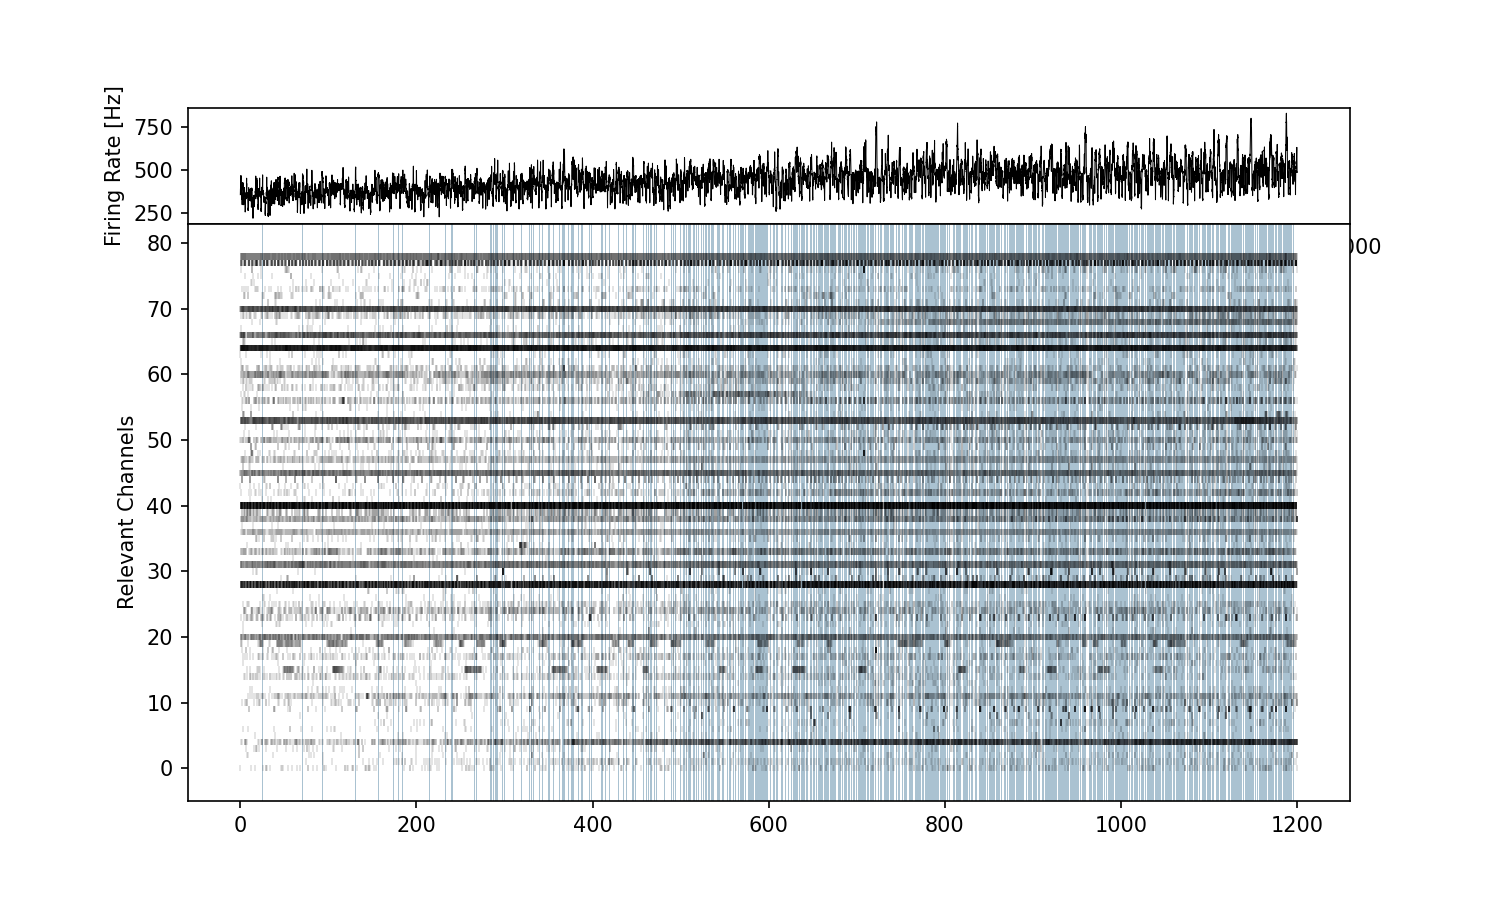

<ipython-input-106-99488327e4c8>:6: MatplotlibDeprecationWarning: "color" keyword argument will be ignored
  axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.1,


In [106]:
fig = plt.figure(figsize = (10,6))
gs = fig.add_gridspec(2, hspace = 0, height_ratios=[1,5])
axs = gs.subplots(sharex=False, sharey=False)
axs[0].plot(ma_fr_gau, color= 'black', linewidth = 0.5)
axs[0].set_ylabel('Firing Rate [Hz]')
axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.1,
                 linelengths = 1, colors = 'black')
axs[1].set_ylabel('Relevant Channels')

for ax in axs:
    for i in bursts_seconds:
        axs[1].axvspan(i[0], i[1], facecolor = '#5B89A6', alpha = 0.3)
#fig.savefig(filename+ '__raster_firingrate_plot.png', dpi=300)

In [107]:
# and lastly for the whole recording

whole_recording_firingrate_dic = {}

for key in spikedic_MAD:
    fr_channel = len(spikedic_MAD[key])/timelengthrecording_s # i.e, number of spikes divided by duration -> results in number per second
    whole_recording_firingrate_dic[key] = fr_channel

In [108]:
# for plotting with sns heatmap we need a df first 

# this is done as empty df:

mea_array=np.empty((16,16,))
mea_array[:]=np.nan
columnlist =['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','R']
df = pd.DataFrame(data=mea_array,columns=columnlist)
df.index+=1

In [109]:
plotframe = copy.deepcopy(df)

In [110]:
plotframe_filled = get_dict_values(plotframe, whole_recording_firingrate_dic)

<IPython.core.display.Javascript object>


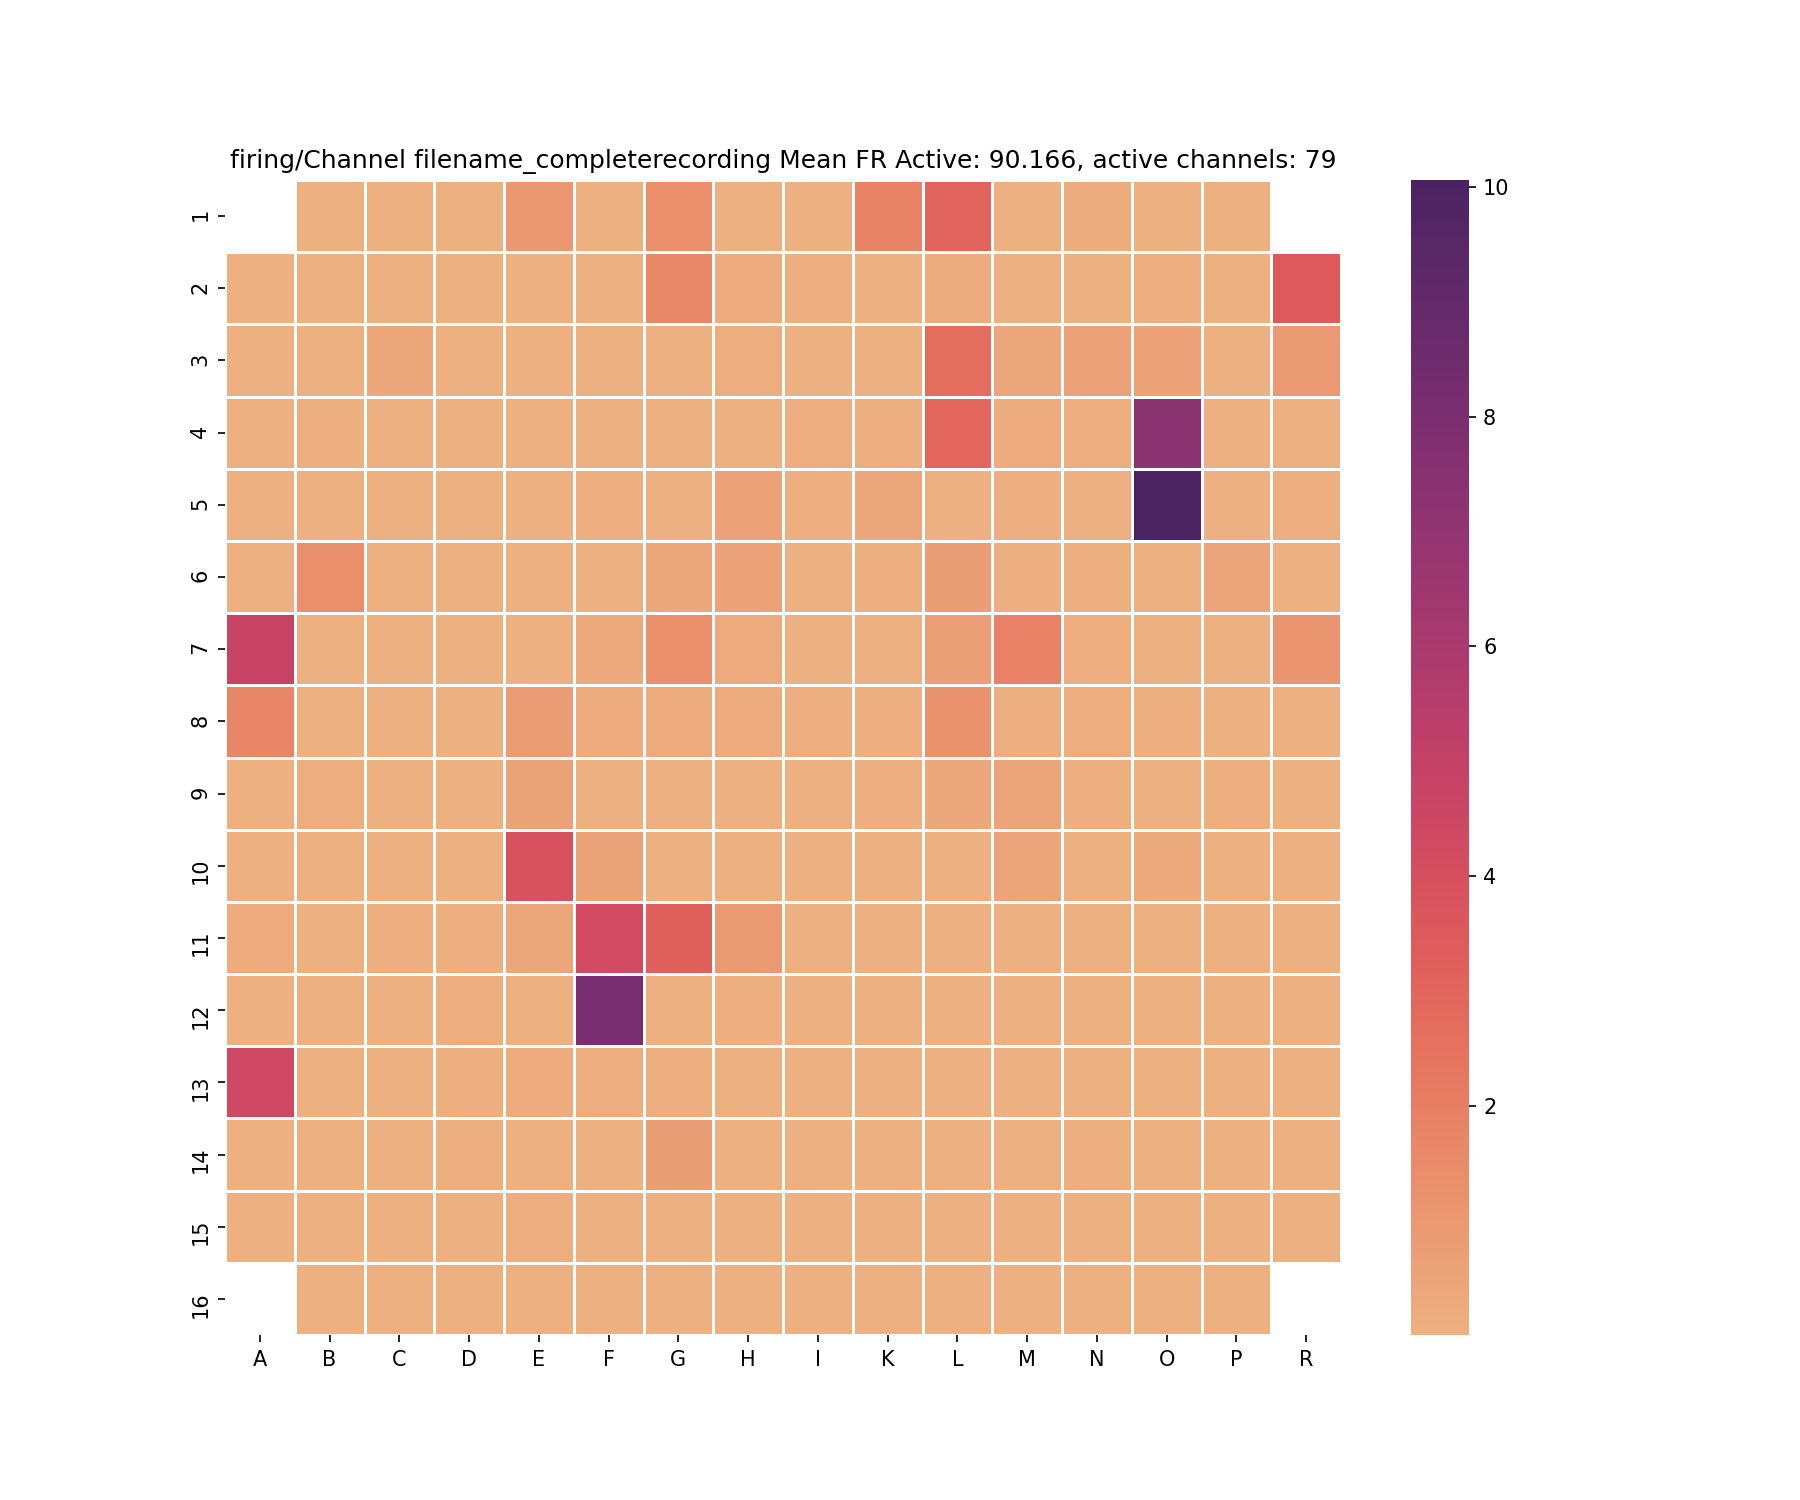

In [111]:
f, ax = plt.subplots(1, 1, figsize = (12,10))

sns.heatmap(plotframe_filled, annot=False, linewidths=.5, ax=ax, cmap="flare")
ax.set_title('firing/Channel ' + filename + ' Mean FR Active: {}, active channels: {}'.format(mean_fr_whole_recording, active_channels))

f.savefig(filename+'whole_MEA_Heatmap.png', dpi = 300, bbox_inches = 'tight')

In [112]:
# normalize the plotframe:

plotframe_normalized =(plotframe_filled-plotframe_filled.mean().max())/plotframe_filled.mean().std()

<IPython.core.display.Javascript object>


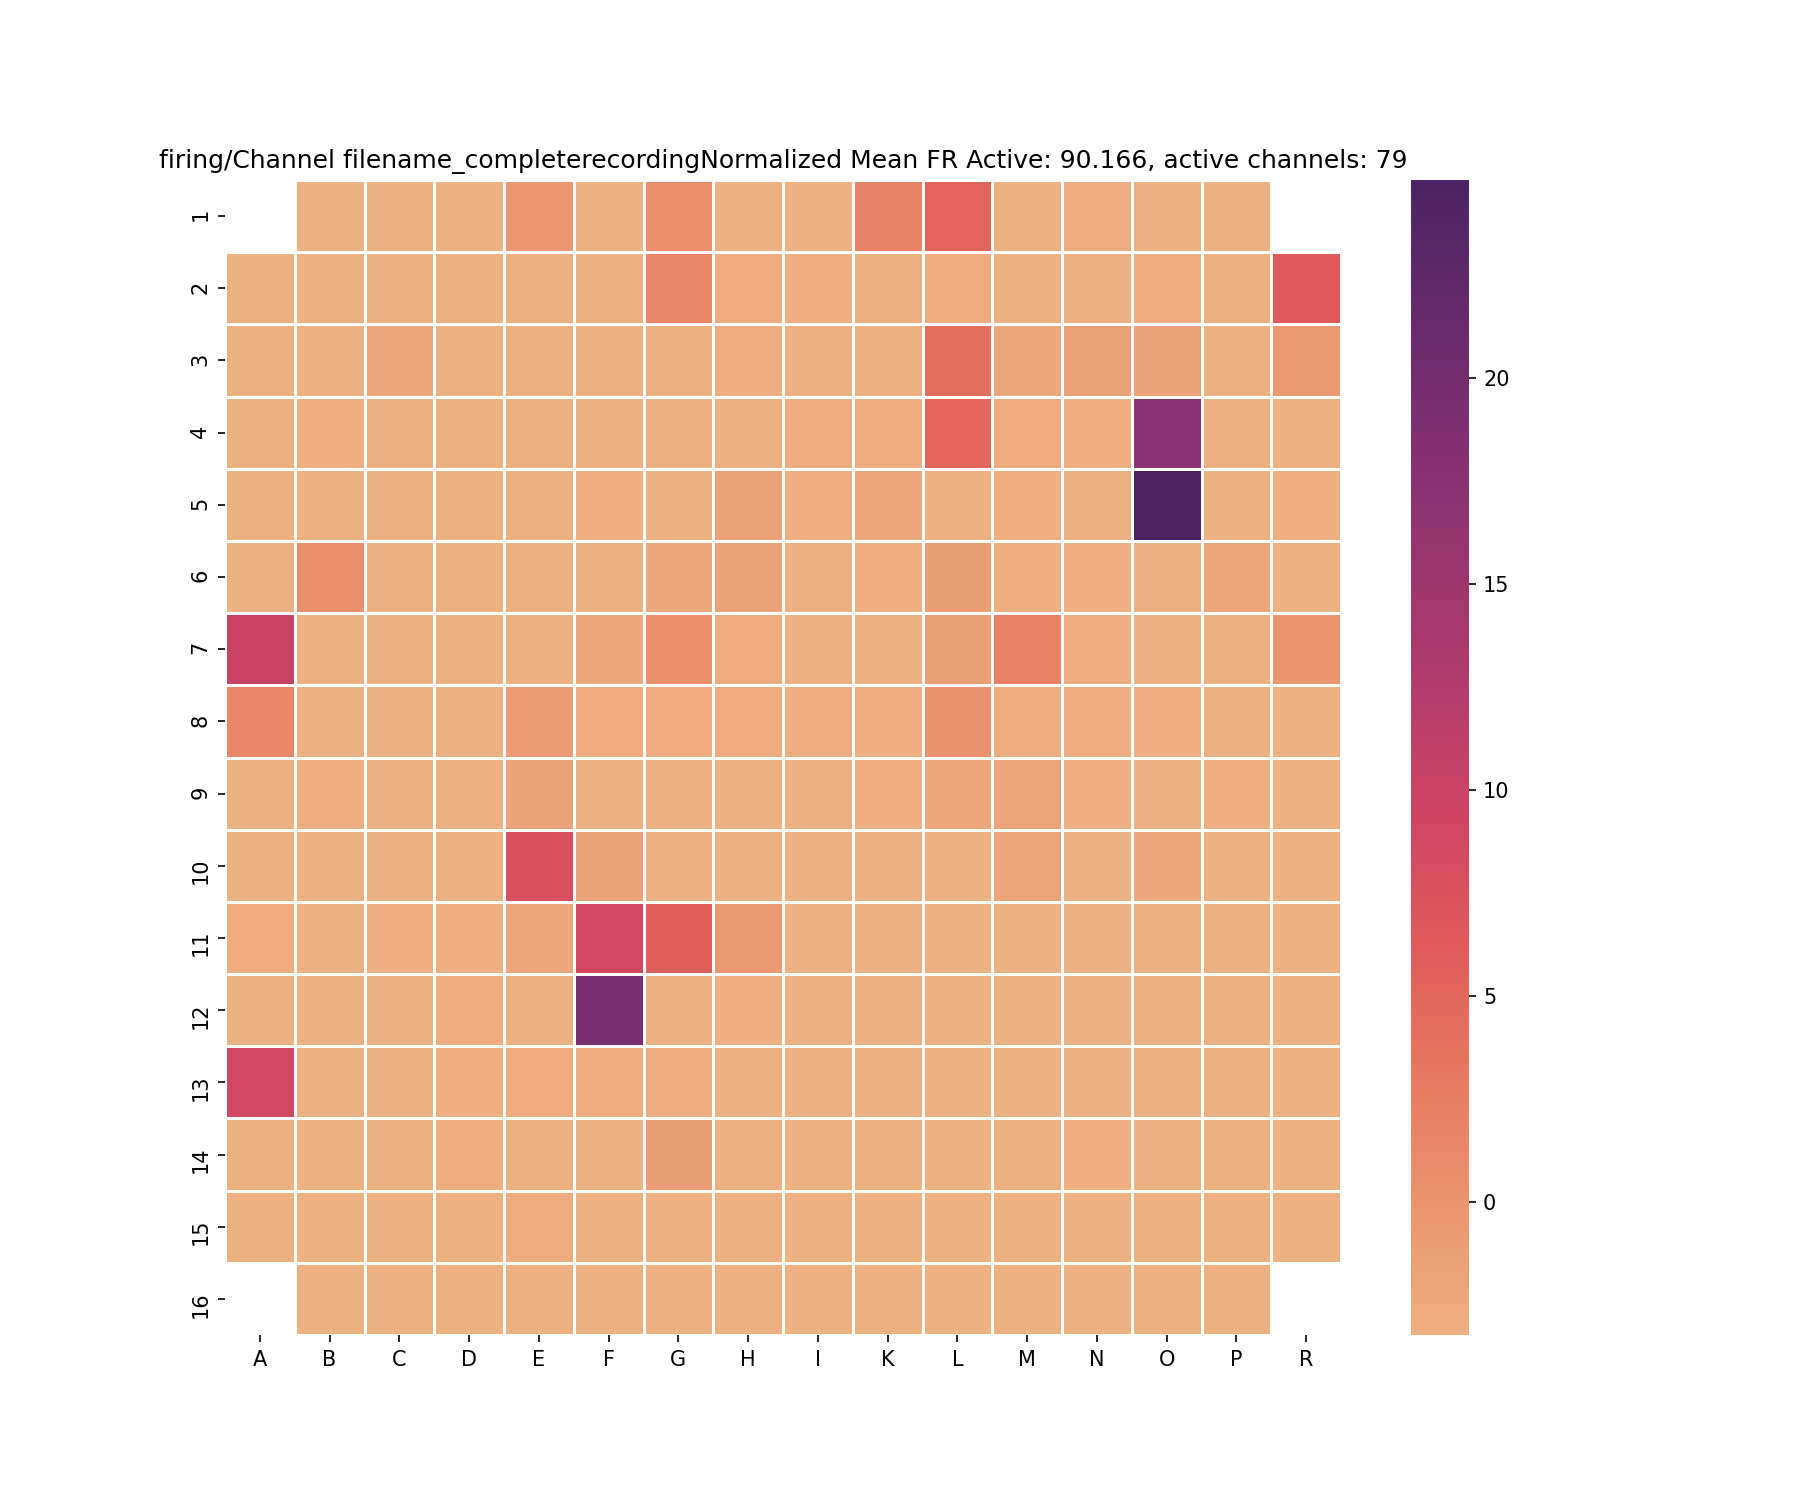

In [113]:
f, ax = plt.subplots(1, 1, figsize = (12,10))

sns.heatmap(plotframe_normalized, annot=False, linewidths=.5, ax=ax, cmap="flare")
ax.set_title('firing/Channel ' + filename + 'Normalized Mean FR Active: {}, active channels: {}'.format(mean_fr_whole_recording, active_channels))

f.savefig(filename+'whole_MEA_Heatmap_normalized.png', dpi = 300, bbox_inches = 'tight')

## basic spiking statistics

next from the whole 20 minute recording we want to calculate the average ISI intervals of the relevant channels and ISI standard deviations for every channel

In [115]:
spikedic_MAD_full

{'R12': [2224970.0,
  13765105.0,
  16018580.0,
  18934794.0,
  22574795.0,
  27157545.0,
  29011810.0,
  29557585.0],
 'L10': [600349.0,
  6437517.0,
  8649684.0,
  8757331.0,
  9531002.0,
  14446031.0,
  16202884.0,
  17476893.0,
  18062095.0,
  22612318.0,
  23328699.0,
  24998539.0,
  26556059.0,
  26942874.0,
  27178380.0,
  27307133.0],
 'O10': [4304.0,
  294378.0,
  402926.0,
  640038.0,
  715492.0,
  723694.0,
  750475.0,
  849978.0,
  1147968.0,
  1183144.0,
  1217935.0,
  1358179.0,
  1455981.0,
  1620411.0,
  1688646.0,
  1931876.0,
  1933063.0,
  2050715.0,
  2171041.0,
  2378092.0,
  2378959.0,
  2432180.0,
  2729293.0,
  2965257.0,
  2969054.0,
  3023184.0,
  3047821.0,
  3182981.0,
  3201976.0,
  3211269.0,
  3298347.0,
  3540982.0,
  3557653.0,
  3560134.0,
  3617340.0,
  3641410.0,
  3642118.0,
  3679272.0,
  3808217.0,
  3843254.0,
  4655456.0,
  4818952.0,
  4823204.0,
  4910040.0,
  5149511.0,
  5247250.0,
  5329469.0,
  5385873.0,
  5415238.0,
  5596287.0,
  563589

In [116]:
def get_isi_single_channel(spikedic):
    
    '''
    input: 
        spikedic with keys = channellabels, values = spiketimes in raw ticks
    
    
    returns: 

        dictionary with keys = channellabels, values = isi per channel in miliseconds
        
        
    nota bene:
        the amount of spikes is not filtered, we still need to factor out non relevant channels
    
    '''
    
    # set the empty dictionary and temporary list
    isi_dictionary = {}
    isi_temp_list =[]
    
    
    for key in spikedic:
        isi_temp_list =[]
        spikes = spikedic[key]
        spikes = [spike * tick * scale_factor_for_milisecond for spike in spikes]
        
        if len(spikes) >= 2:
            for i in range(0, len(spikes)-1): 

                # calculate the isi
                isi =  spikes[i+1] - spikes[i] 
                isi_temp_list.append(isi)

        isi_dictionary[key] = isi_temp_list
        
    
    return isi_dictionary
        

In [129]:
# create the dictionary with isi
isi_dictionary = get_isi_single_channel(spikedic_MAD_full)


In [130]:
# now we get the average isi and isi std

# creating list to easily calculate the whole mean and std
isi_averages = []
isi_standarddeviations = []

# creat dictionaries to do the same for every channel
isi_average_dic = {}
isi_standarddeviations_dic = {}



for key in isi_dictionary:
    if len(isi_dictionary[key]) > relevant_factor:
        
        # for the relevant channels we attain the mean
        mean_isi = np.mean(isi_dictionary[key])
        isi_averages.append(mean_isi)
        
        # and the standard deviation
        std_isi = np.std(isi_dictionary[key])
        isi_standarddeviations.append(std_isi)
        
        isi_average_dic[key] = mean_isi
        isi_standarddeviations_dic[key] = std_isi
        
        
        
mean_isi_relevant_channels = np.mean(isi_averages)
mean_isi_std = np.mean(isi_standarddeviations)

In [140]:
mean_isi_relevant_channels

4916.105554158514

In [131]:
# now we get the average isi and isi std

# creating list to easily calculate the whole mean and std
isi_averages = []
isi_standarddeviations = []

# creat dictionaries to do the same for every channel
isi_average_dic = {}
isi_standarddeviations_dic = {}

for key in isi_dictionary:
    if len(isi_dictionary[key]) > relevant_factor:
        
        # for the relevant channels we attain the mean
        mean_isi = np.mean(isi_dictionary[key])
        isi_averages.append(mean_isi)
        
        print(mean_isi)

3295.78967032967
2802.525685785536
10740.31063063063
6995.1759999999995
285.2164565992866
16336.758235294119
10405.735087719298
5119.020990099009
7884.031328671329
1639.312551724138
2250.8712781954887
807.2129084745764
6480.9849180327865
15804.60303030303
2208.2950092421443
1451.5014669926652
8262.856666666667
1625.6010340136054
5429.478899082568
1368.356894977169
376.0364491844417
19433.823606557376
10010.645811965813
1596.7490812250333
965.8609046849758
2140.532759856631
16466.678309859155
15067.011052631577
135.95839419369472
2298.5636000000004
2790.9383529411766
337.7870233736976
15612.219444444441
540.4630401443392
10730.84509090909
3957.5092617449664
605.9902730030334
14569.314936708863
519.5818370883883
875.1319970738843
99.17372753623187
16176.058630136986
1082.5557400722023
4925.823703703704
1517.3580228136882
327.4144144144144
5049.605063291139
716.0386618876943
3603.7248338368586
3320.5302824858754
737.7487822878229
4302.68489208633
1757.4939027982325
230.77264332435556
8069

In [132]:
isi_dictionary

{'R12': [461605.39999999997,
  90139.00000000012,
  116648.55999999994,
  145600.04000000004,
  183310.0,
  74170.6000000001,
  21831.0],
 'L10': [233486.72,
  88486.68,
  4305.880000000005,
  30946.840000000026,
  196601.15999999997,
  70274.12,
  50960.359999999986,
  23408.080000000075,
  182008.91999999993,
  28655.23999999999,
  66793.6000000001,
  62300.80000000005,
  15472.59999999986,
  9420.23999999999,
  5150.120000000112],
 'O10': [11602.960000000001,
  4341.92,
  9484.48,
  3018.16,
  328.08000000000175,
  1071.239999999998,
  3980.1200000000026,
  11919.599999999999,
  1407.0400000000009,
  1391.6399999999994,
  5609.760000000002,
  3912.0799999999945,
  6577.200000000004,
  2729.399999999994,
  9729.200000000012,
  47.479999999995925,
  4706.080000000002,
  4813.039999999994,
  8282.040000000008,
  34.679999999993015,
  2128.8399999999965,
  11884.520000000004,
  9438.559999999998,
  151.88000000000466,
  2165.199999999997,
  985.4799999999959,
  5406.400000000009,
  759.

In [133]:
mean_isi_std

6367.877143553076

In [134]:
mean_fr_whole_recording

90.166

In [135]:
active_channels

79

## reference to the anatomy



In [136]:
#layerdic 23.10.2019
layerdic = {'layer1':[ ], 
            'layer2-3': ['D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'I2', 'K1', 'K2', 'L1', 'L2', 'L3', 'M1', 'M2', 
                        'M3', 'M4', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 
                        'O7', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'R2', 'R3', 'R4', 'R5', 
                        'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 'R13', 'R14', 'R15'],
           'layer4':    ['B1', 'B2', 'C1', 'C2', 'D2', 'E2', 'F2', 'G2', 'G3', 'H2', 'H3', 'I3', 'K3', 'K4', 
                         'L4', 'L5', 'M5', 'M6', 'M7', 'N7', 'N8', 'O8', 'O9', 'O10', 'O11', 'P10', 'P11', 
                         'P12', 'P13', 'P14', 'P15', 'P16' ],
           'layer5-6':  ['A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'B3', 'B4', 'B5', 'B6', 
                         'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
                          'C11', 'C12', 'C13', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 
                         'D13', 'D14', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 
                         'E15', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 
                         'F16', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16', 
                         'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'I4', 
                         'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'K5', 'K6', 
                         'K7', 'K8', 'K9', 'K10', 'K11', 'K12', 'K13', 'K14', 'K15', 'K16', 'L6', 'L7', 'L8', 'L9', 
                         'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 
                         'M14', 'M15', 'M16', 'N9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'O12', 'O13', 
                         'O14', 'O15', 'O16'],
           'whitematter':['A12', 'A13', 'A14', 'A15', 'B13', 'B14', 'B15', 'B16', 'C14', 'C15', 'C16', 'D15', 'D16', 'E16'  ]}

In [137]:
def invert_layerdic(layer_dic):
    
    '''
    Expects a dictionary with key = layer, value = list of channellabels
    
    Returns a dictionary with key = channellabels, value = layer
    '''
    layerdic_invert = {}

    for key in layerdic:
        for i in layerdic[key]:
            layerdic_invert[i]=key
            
            
    return layerdic_invert

In [138]:
layerdic_invert = invert_layerdic(layerdic)

In [139]:
isi_average_dic

{}

In [128]:
isi_standarddeviations_dic

{}

In [422]:
layerdic_invert

{'D1': 'layer2-3',
 'E1': 'layer2-3',
 'F1': 'layer2-3',
 'G1': 'layer2-3',
 'H1': 'layer2-3',
 'I1': 'layer2-3',
 'I2': 'layer2-3',
 'K1': 'layer2-3',
 'K2': 'layer2-3',
 'L1': 'layer2-3',
 'L2': 'layer2-3',
 'L3': 'layer2-3',
 'M1': 'layer2-3',
 'M2': 'layer2-3',
 'M3': 'layer2-3',
 'M4': 'layer2-3',
 'N1': 'layer2-3',
 'N2': 'layer2-3',
 'N3': 'layer2-3',
 'N4': 'layer2-3',
 'N5': 'layer2-3',
 'N6': 'layer2-3',
 'O1': 'layer2-3',
 'O2': 'layer2-3',
 'O3': 'layer2-3',
 'O4': 'layer2-3',
 'O5': 'layer2-3',
 'O6': 'layer2-3',
 'O7': 'layer2-3',
 'P1': 'layer2-3',
 'P2': 'layer2-3',
 'P3': 'layer2-3',
 'P4': 'layer2-3',
 'P5': 'layer2-3',
 'P6': 'layer2-3',
 'P7': 'layer2-3',
 'P8': 'layer2-3',
 'P9': 'layer2-3',
 'R2': 'layer2-3',
 'R3': 'layer2-3',
 'R4': 'layer2-3',
 'R5': 'layer2-3',
 'R6': 'layer2-3',
 'R7': 'layer2-3',
 'R8': 'layer2-3',
 'R9': 'layer2-3',
 'R10': 'layer2-3',
 'R11': 'layer2-3',
 'R12': 'layer2-3',
 'R13': 'layer2-3',
 'R14': 'layer2-3',
 'R15': 'layer2-3',
 'B1':

In [423]:
layerdic

{'layer1': [],
 'layer2-3': ['D1',
  'E1',
  'F1',
  'G1',
  'H1',
  'I1',
  'I2',
  'K1',
  'K2',
  'L1',
  'L2',
  'L3',
  'M1',
  'M2',
  'M3',
  'M4',
  'N1',
  'N2',
  'N3',
  'N4',
  'N5',
  'N6',
  'O1',
  'O2',
  'O3',
  'O4',
  'O5',
  'O6',
  'O7',
  'P1',
  'P2',
  'P3',
  'P4',
  'P5',
  'P6',
  'P7',
  'P8',
  'P9',
  'R2',
  'R3',
  'R4',
  'R5',
  'R6',
  'R7',
  'R8',
  'R9',
  'R10',
  'R11',
  'R12',
  'R13',
  'R14',
  'R15'],
 'layer4': ['B1',
  'B2',
  'C1',
  'C2',
  'D2',
  'E2',
  'F2',
  'G2',
  'G3',
  'H2',
  'H3',
  'I3',
  'K3',
  'K4',
  'L4',
  'L5',
  'M5',
  'M6',
  'M7',
  'N7',
  'N8',
  'O8',
  'O9',
  'O10',
  'O11',
  'P10',
  'P11',
  'P12',
  'P13',
  'P14',
  'P15',
  'P16'],
 'layer5-6': ['A2',
  'A3',
  'A4',
  'A5',
  'A6',
  'A7',
  'A8',
  'A9',
  'A10',
  'A11',
  'B3',
  'B4',
  'B5',
  'B6',
  'B7',
  'B8',
  'B9',
  'B10',
  'B11',
  'B12',
  'C3',
  'C4',
  'C5',
  'C6',
  'C7',
  'C8',
  'C9',
  'C10',
  'C11',
  'C12',
  'C13',
  'D3

In [ ]:
def layer_basic_infos (spikedic, layerdic)



    '''
    INPUT: spikedic, layerdic
    
    Returns: a dictionary with key = layer and value = list with [mean_fr, mean_isi, std_isi]
    
    
    
    '''